

# Predicción de Series Temporales utilizando FbProphet

La predicción de series temporales es de los casos más habituales y aplicables dentro del Machine Learning. Por ejemplo, models de 'forecasting' se pueden encontrar en para la predicción de precios, demanda, temperatura,  tiempo de respuesta, ventas, ritmo cardiaco, producción, etc. 

El gran reto se encuentra en que, a diferencia de algunos otros casos de Machine Learning, la predicción a futuro depende en gran medida, de los datos históricos de la serie. Es decir, por ejemplo si queremos predecir la temperatura media por hora, el dato más relevante que podemos utilizar es la misma serie de temperaturas por hora. A este tipo de modelos se los llama **Auto-regresivos.** 

En la práctica, los modelos auto-regresivos pueden desarrollarse sin ninguna otra variable auxiliar (covariantes), sin embargo, es común añadir regresores externos para complementar el poder predictivo del modelo. 

## Caso de uso: Predicción de la demanda de Bicicletas en una plataforma de BikeSharing en Washington DC. 
Somos Data Scientist en una empresa de Bike Sharing. Básicamente es una aplicación en donde los usuarios pueden registrarse, utilizar bicicletas de nuestra empresa que están localizadas a lo largo de la ciudad, y luego, cuándo llegan a destino, las dejan para que otros usuarios puedan usarlas también. La empresa está en proceso de expansión, por lo que han decidido comprar nuevas bicicletas para colocar en la ciudad. Sin embargo, se ha decidido que se comprarán las bicicletas en función de la cantidad de demanada diaria en el futuro. Por lo que se nos ha pedido que realicemos un modelo de predicción de la demanda. La compra tendrá que hacerse urgentemente, por lo que el reto será predecir la demanda de las siguientes dos semanas. 

- Para ello tenemos datos históricos de demanda y la siguiente información:
    - instant: identificador de la fila.
    - dteday: fecha.
    - hr: hora.
    - weathersit: descripción de la situación climática
    - temp: temperatura en celcius (normalizado con división por 41 (max))
    - atemp: sensación térmica (normalizado, dividido por 50 (max))
    - hum: humedad normalizada. Valores divividos por 100 (max)
    - windspeed: velocidad del viento normalizada
    - casual: conteo de usuarios casuales (no registrados)
    - registered: conteo de usuarios registrados en la app
    - cnt: conteo total usuarios (registrados y casuales). Esta sería la variable objetivo.

Reto: Predecir la demanda del siguiente mes!



# Importamos paquetes y definimos helpers

In [1]:
# Instalar paquetes. - Recomendado crear un nuevo environment
# Prophet no es fácil de instalar, sobre todo en Windows. 
# python -m pip install prophet
# pip install dabl
# pip install plotly
# pip install seaborn


# Para Windows, instala FBProphet siguiendo estos pasos. 
# https://stackoverflow.com/questions/53178281/installing-fbprophet-python-on-windows-10


In [45]:
import prophet
import sklearn
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import mean_squared_error , r2_score 
import seaborn as sns
from prophet import Prophet
import holidays

# Set up

def get_median_filtered(signal: pd.Series, threshold: int = 3):
    
    """
    Función que nos permite sacar outliers utilizando el método de la mediana
    filtrada. Es bastante robusto a ruido, por lo que es ideal para series 
    temporales. 
     
    Directamente reemplaza outliers con la mediana!
    Info sobre el método en 
    https://en.wikipedia.org/wiki/Median_filter 
    :param signal: una serie o señal
    :param threshold: desviaciones respecto a la mediana    
    :return:   array igual a serie con los outliers reemplazados. 
    
    """
    
    signal = signal.copy()
    difference = np.abs(signal - np.median(signal))
    median_difference = np.median(difference)
    if median_difference == 0:
        s = 0
    else:
        s = difference / float(median_difference)
    mask = s > threshold
    signal[mask] = np.median(signal)
    return signal

def plot_outliers_signal(
        signal: pd.Series, threshold: int = 3, return_mask: bool = True
    ):
    
    """
    Funcion que plotea los resultados de la funcion
    get_median_filtered
    
    :param signal: una serie o señal
    :param threshold: desviaciones respecto a la mediana   
    :param return_mask: Si es True, devuelve los índices donde hubo reemplazo 
    :return:  in plot
    
    """
    
    
    kw = dict(marker='o', linestyle='none', color='r', alpha=0.35)

    mds = get_median_filtered(signal, threshold=threshold)
    outlier_idx = np.where(mds != signal)[0]
    plt.figure(figsize=(10,8))

    plt.plot(signal, color = "darkblue")
    plt.plot(outlier_idx,signal[outlier_idx],**kw, 
            label = "Outliers")
    plt.title("Detección de Outliers con cutoff {}".format(threshold))
    plt.legend()
    plt.show()
    if return_mask: 
      return outlier_idx


def mean_absolute_percentage_error(y_true: pd.Series, y_pred: pd.Series): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

def evaluate(true: pd.Series, pred: pd.Series):
    print("........................................................")
    print('Mean squared error: %.2f'% mean_squared_error(true, pred))
    print()
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'% r2_score(true, pred))
    print()
    print('MAPE: %.2f'%  mean_absolute_percentage_error(true, pred))
    print("..........................................................")

## Cargamos los Datos y exploración inicial 

In [7]:
#gdrive location:
url = 'https://raw.githubusercontent.com/patofw/ml_tutorials/main/DATA/forecasting_exercise.csv'
df = pd.read_csv(url, parse_dates=["dteday"]) 
df.head(2)

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40


In [8]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   hr          17379 non-null  int64         
 3   weathersit  17279 non-null  object        
 4   temp        17280 non-null  float64       
 5   atemp       17279 non-null  float64       
 6   hum         17279 non-null  float64       
 7   windspeed   17279 non-null  float64       
 8   casual      17379 non-null  int64         
 9   registered  17379 non-null  int64         
 10  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 1.5+ MB
None


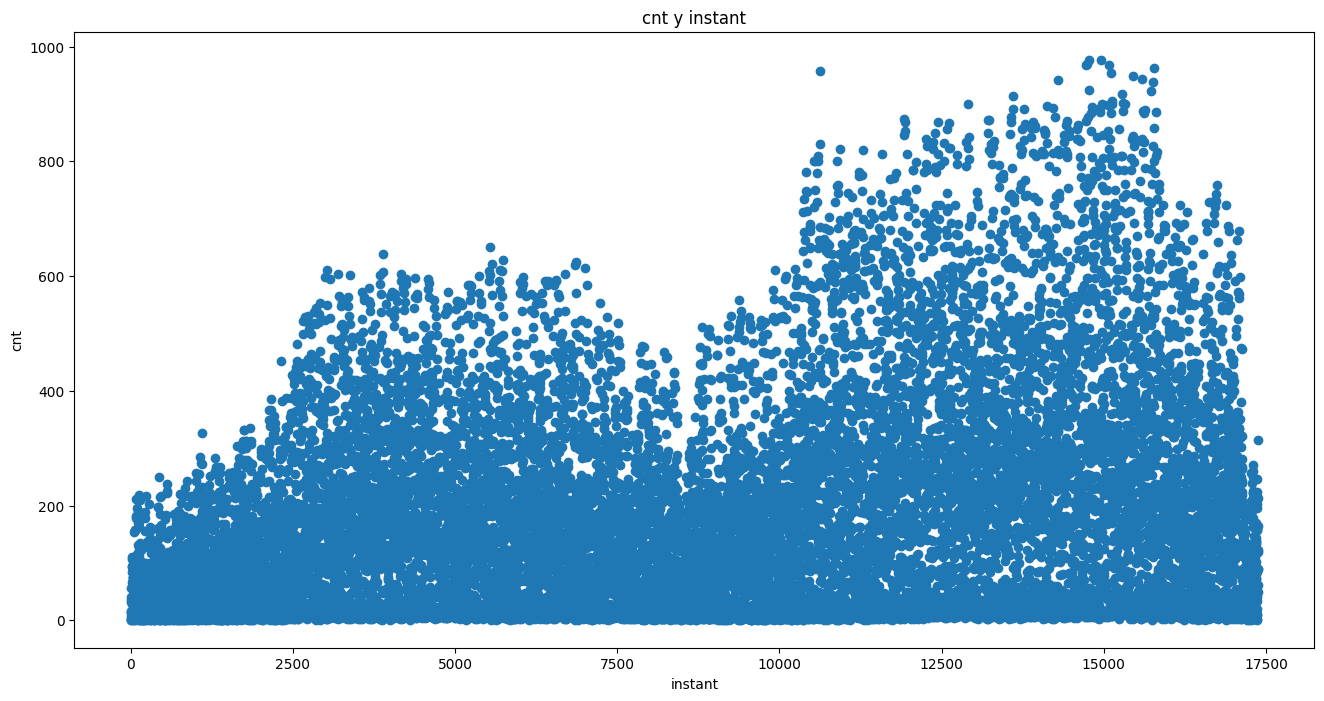

In [9]:
x = 'instant'
y = 'cnt' 

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df[x], df[y])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_title(f'{y} y {x}')
plt.show()

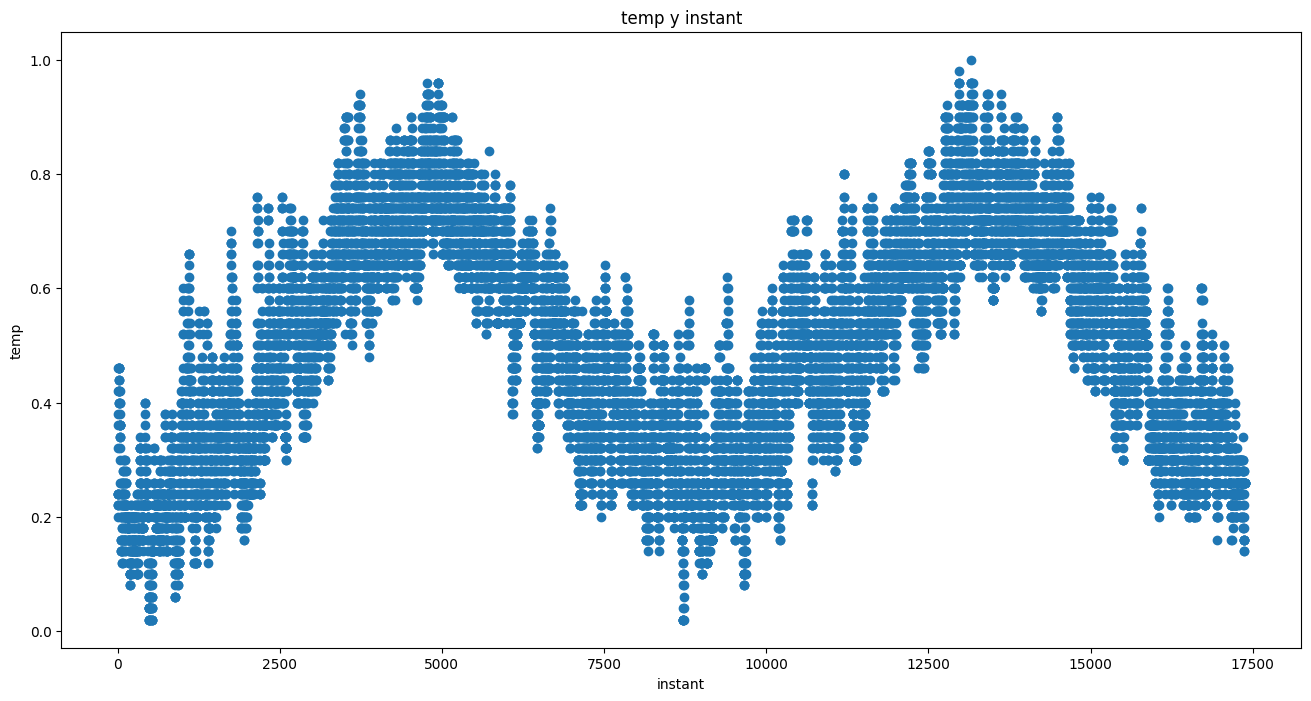

In [10]:
x = 'instant'
y = 'temp'
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df[x], df[y])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_title(f'{y} y {x}')
plt.show()

In [11]:
df.head()

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,0,1,1


<Axes: >

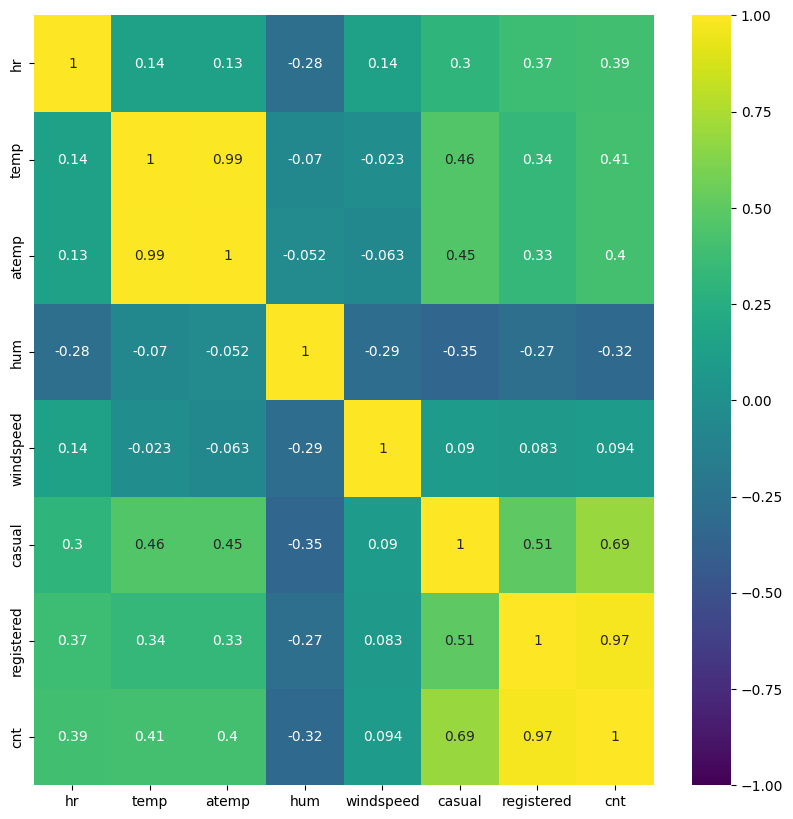

In [12]:
plt.figure(figsize=(10,10))
# HEAT MAP
sns.heatmap(
    df.drop(['weathersit', 'dteday', 'instant'], axis=1).corr(),
    annot=True,
    cmap="viridis", 
    vmin=-1,
    vmax=1
)

# Formato Datos 

Los datos están por hora, lo que dificulta en gran medida el análisis ya que se agrega muchísimo ruido de horas poco útiles. Para este caso de uso, trabajaremos con predicción de la demanda diaria. 

In [13]:
df_byday = df.groupby(
    'dteday'
)['cnt'].sum().reset_index() # Sum of cnt by day 

In [14]:
df_byday.head()

,dteday,cnt
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1349
3,2011-01-04,1562
4,2011-01-05,1600


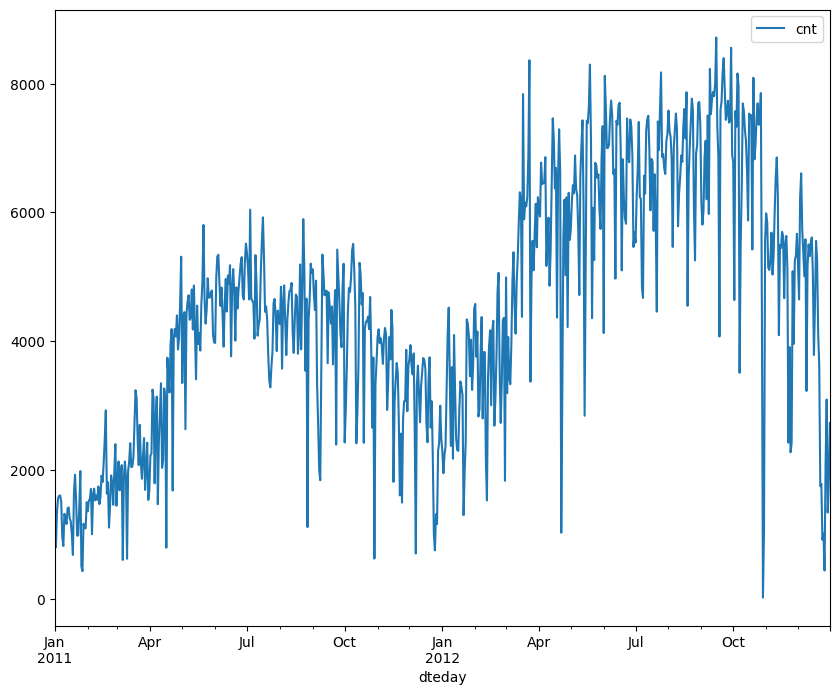

In [15]:
df_byday.plot(x='dteday',y='cnt', figsize=(10,8))
plt.show()

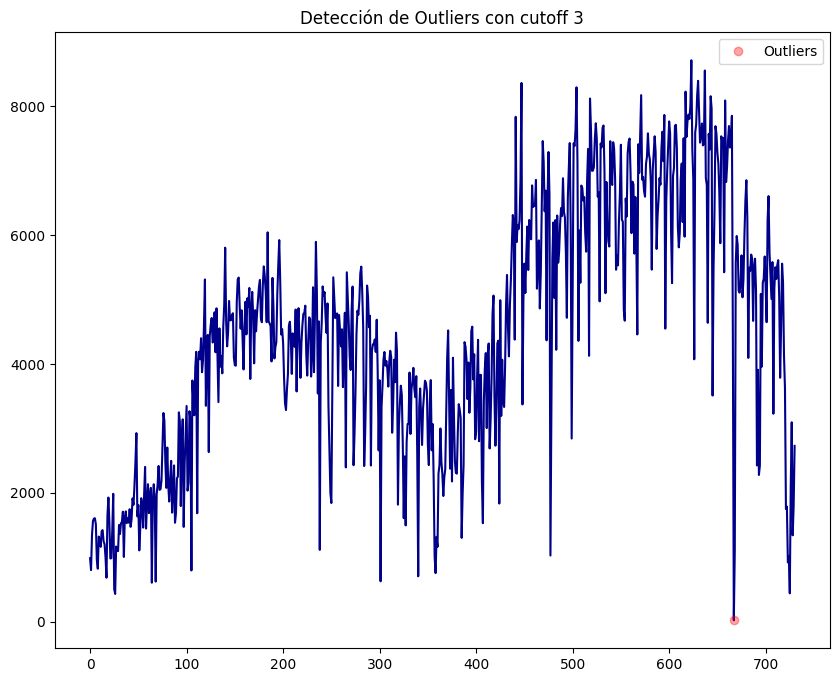

In [16]:
# Outliers
indices = plot_outliers_signal(
    df_byday.cnt.values, threshold=3
)
plt.show()

In [17]:
df_byday.iloc[indices]

,dteday,cnt
667,2012-10-29,22


Agregamos todas las variables que nos eran útiles. Sin embargo, no todas las podemos tratar de la misma forma

# Feature Engineering ( Creamos variables a raíz de nuestros datos)

In [18]:
# ha llovido ??
rain_flag =[
    'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
    'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'
]
df['rain'] = [
    1 if x in rain_flag else 0 for x in df.weathersit.values
]


In [19]:

# Con las fechas y dt. podemos extraer variables relevantes! Por ejemplo 
df_byday["dayofweek"] = df_byday.dteday.dt.dayofweek #to know working day or not if monday(1) -friday (5) yes + if holiday 
df_byday["dayofyear"] = df_byday.dteday.dt.dayofyear
# La temporada influye muchísimo, si hace frío no se sale a montar bicicleta
conditions = [
    (df_byday['dayofyear'] >= 61) & (df_byday['dayofyear'] <= 150),
    (df_byday['dayofyear'] >= 151) & (df_byday['dayofyear'] <= 240),
    (df_byday['dayofyear'] >= 241) & (df_byday['dayofyear'] <= 330),
    (df_byday['dayofyear'] >= 331) |  (df_byday['dayofyear'] <= 60)
]
#create a list of the values we want to assign for each condition
values = [1, 2, 3, 4]
#create a new column and use np.select to assign values to it using our lists as arguments
df_byday['season'] = np.select(conditions, values)
# 
us_holidays =  holidays.US()
  
conditions2 = [
    (df_byday['dayofweek'].isin([1, 2, 3, 4, 5])) & 
    (~df_byday['dteday'].isin(us_holidays)),  #workdays
    (df_byday['dayofweek'].isin([6, 0]))
    ]

values2 = [1 ,0]
#create a new column and use np.select to assign values to it using our lists as arguments
df_byday['is_workday'] = np.select(conditions2, values2)

# Re append the temperature and rain flag 
df_byday['temp'] = df.groupby('dteday')['temp'].mean().values # mean temp
df_byday['rain'] = df.groupby('dteday')['rain'].mean().values # mean of rain**
# ** Si llueve todo el día, la media estará cerca de 1, si llueve poco, cerca a 0



In [20]:
df_byday.head()

,dteday,cnt,dayofweek,dayofyear,season,is_workday,temp,rain
0,2011-01-01,985,5,1,4,1,0.344167,0.083333
1,2011-01-02,801,6,2,4,0,0.363478,0.217391
2,2011-01-03,1349,0,3,4,0,0.197143,0.000000
3,2011-01-04,1562,1,4,4,1,0.200000,0.000000
4,2011-01-05,1600,2,5,4,1,0.226957,0.000000


<Axes: >

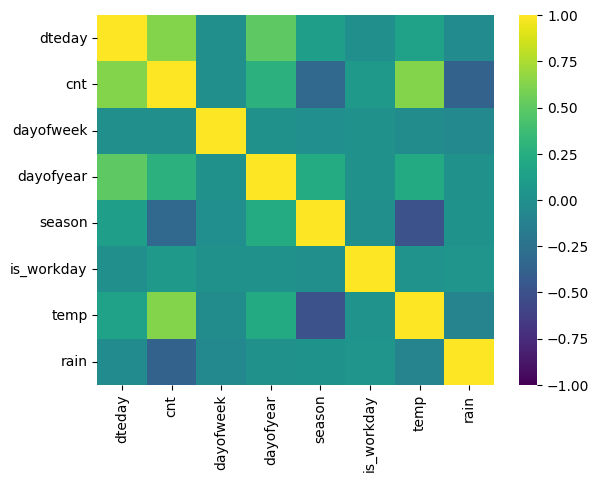

In [21]:
# Veamos correlación entre variables 
sns.heatmap(
    df_byday.dropna().corr(),
    # annot=True,
    cmap="viridis", 
    vmin=-1,
    vmax=1
)

Text(0.5, 1.0, 'Bike use by season and workday')

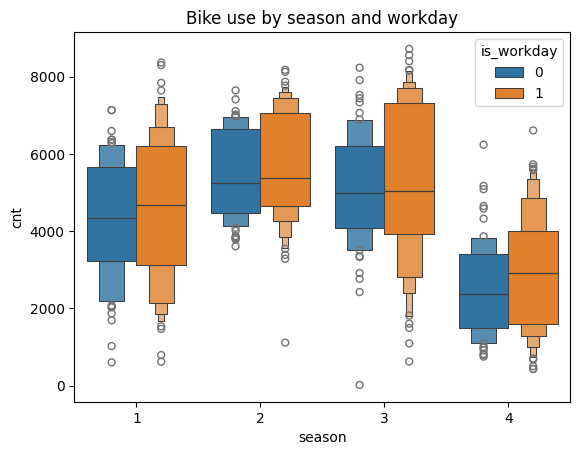

In [22]:
sns.boxenplot(
    data=df_byday, 
    x='season', 
    hue='is_workday',y='cnt'
)
plt.title('Bike use by season and workday')

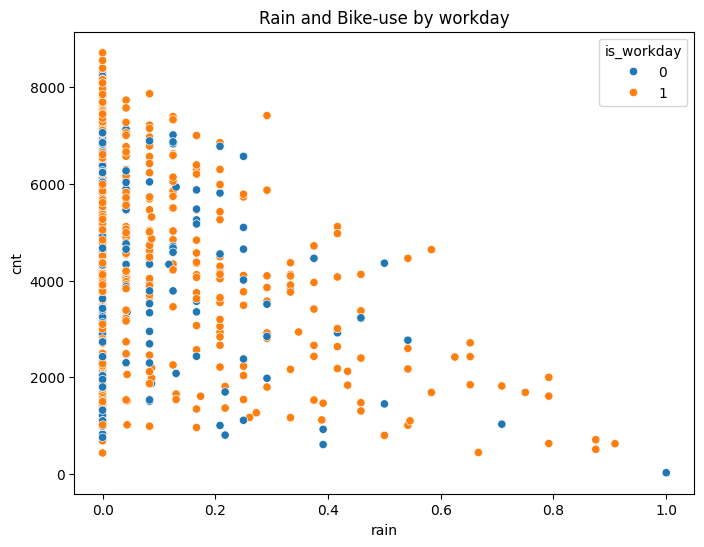

In [23]:
fig = plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_byday, x='rain', y='cnt', hue='is_workday')
plt.title('Rain and Bike-use by workday');

In [24]:
abs(df_byday.corr()['cnt']).sort_values(ascending=False)

cnt           1.000000
dteday        0.628830
temp          0.627631
rain          0.369099
season        0.330136
dayofyear     0.277433
is_workday    0.072436
dayofweek     0.003985
Name: cnt, dtype: float64

# Modelo de Machine Learning

In [25]:
# separación train test

ext_reg = ["temp", 'rain', 'season', 'dayofyear', 'is_workday']
target = 'cnt' # our target var

train_cut = "2012-12-01"
# Separamos test de train
train = df_byday[df_byday.dteday < train_cut]
test = df_byday.copy()
# Formato para  Prophet 
train_proph = train[['dteday', target] + ext_reg]
#test dataset
X_test = test[train_proph.columns]
y_test = test[target]
X_test[target] = np.nan # quitamos valores del X_test en la target var 
 
# Llenamos NA ->  Usamos la temperatura del día anterior para llenar nulos 

train_proph['temp'] = train_proph.temp.fillna(method='ffill') # forward fill
X_test['temp'] = X_test.temp.fillna(method='ffill') # forward fill

# Renombramos la variable cnt cnt name a y como pide Prophet 
train_proph.rename(columns={target:'y', 'dteday':'ds'}, inplace=True)
X_test.rename(columns={target:'y', 'dteday':'ds'}, inplace=True)

/var/folders/gm/82lk2qqj3737203ydr7y53r80000gq/T/ipykernel_94710/3196639095.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[target] = np.nan # quitamos valores del X_test en la target var
/var/folders/gm/82lk2qqj3737203ydr7y53r80000gq/T/ipykernel_94710/3196639095.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_proph['temp'] = train_proph.temp.fillna(method='ffill') # forward fill
/var/folders/gm/82lk2qqj3737203ydr7y53r80000gq/T/ipykernel_94710/3196639095.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [26]:
# Try basic Prophet model first, adding external regressors (covariates)
m = Prophet()  # Prophet por defect
for reg in ext_reg: # adding regressors to the Prophet model 
  m.add_regressor(
    reg, mode='additive'
  )
# Train the model.
m.fit(train_proph)

21:42:40 - cmdstanpy - INFO - Chain [1] start processing
21:42:40 - cmdstanpy - INFO - Chain [1] done processing


/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


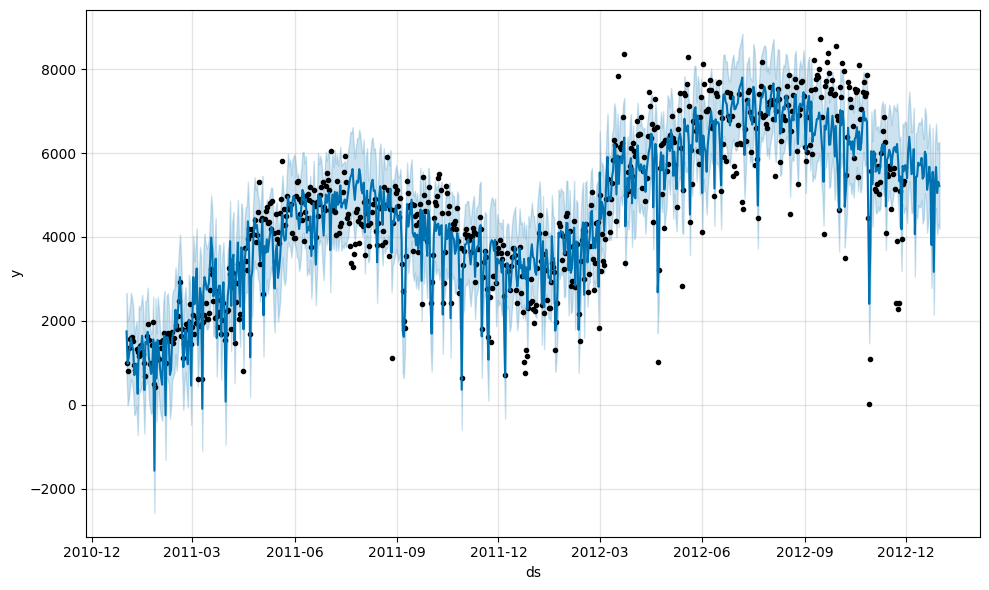

In [27]:
# predict
forecast = m.predict(X_test)
fig = m.plot(forecast)

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


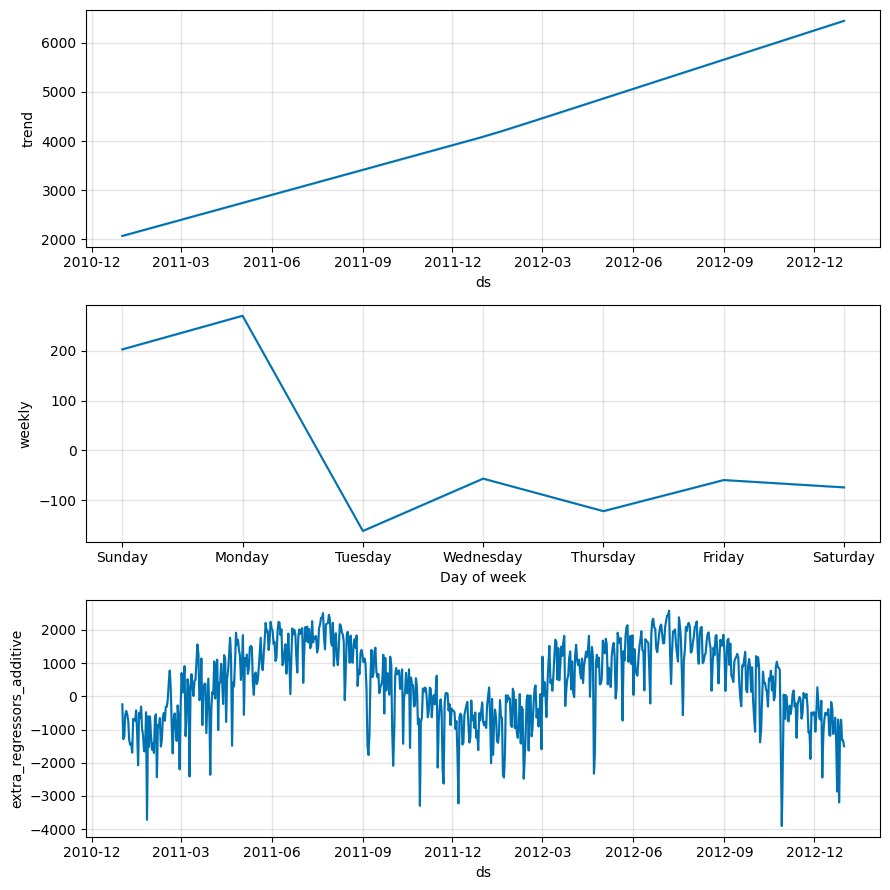

In [28]:
fig = m.plot_components(forecast);

In [29]:
predicted = forecast[forecast.ds >= train_cut].yhat
real = y_test[
    -len(predicted):
]

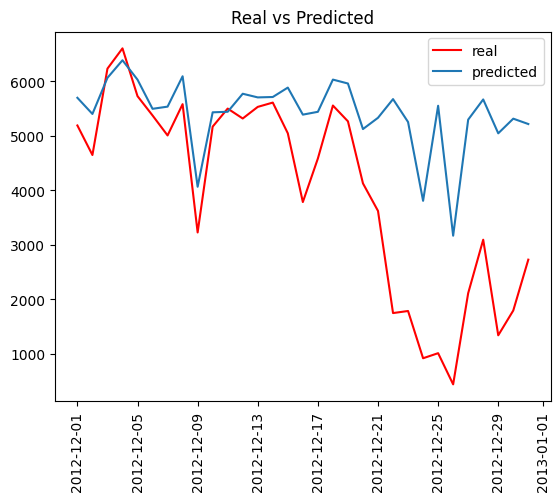

In [30]:
x = X_test.ds[-len(predicted):]
plt.plot(x, real, c='red', label='real')
plt.plot(x, predicted, label='predicted')
plt.legend()
plt.xticks(rotation='vertical')
plt.title('Real vs Predicted');

In [31]:
# imprimios evaluación
evaluate(real, predicted)

........................................................
Mean squared error: 4003438.53

Coefficient of determination: -0.27

MAPE: 0.93
..........................................................


/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a

## Optimización de Hyperparámetros

Prophet da resultados decentes en su versión "out-of-the-box", pero se puede llegar mucho más lejos si se optimiza en hyper-parámetros. Prophet nos permite optimizar en varios parámetros de forma eficiente, obteniendo los mejores resultados posibles para nuestro modelo. Mientras más grande el search-space, más tiempo demorará la optimización.

Más información en el siguiente [link](https://facebook.github.io/prophet/docs/diagnostics.html)

In [28]:
import itertools 
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

cv_forecast_horizon = '21 d'

TRAIN_GRID = {  
  'changepoint_prior_scale': [0.3, 0.5 ,0.7],
  'seasonality_prior_scale': [7, 10],
  'yearly_seasonality': [7, 10],
  'seasonality_mode': ['additive', 'multiplicative'],
  'changepoint_range': [0.5, 0.7, 0.9],
}

all_params = [
  dict(zip(
    TRAIN_GRID.keys(),
    v)) for v in itertools.product(
    *TRAIN_GRID.values())]

tuning_results = pd.DataFrame()
# Use cross validation to evaluate all parameters # it can be parallelized.
i = 1
n_params = len(all_params)
for params in all_params:
  print("Fitting {}/{}".format(i,n_params))
  print(params)
  # Fit model with given params
  m = Prophet(**params)  
  for reg in ext_reg: # adding regressors to the Prophet model 
      m.add_regressor(
        reg,
        prior_scale=0.25,  # weight of regressor 
        mode='additive'
  )
  # fit the model 
  m.fit(train_proph)
  # Crossvalidate time series 
  df_cv = cross_validation(m,
                          initial='100 days',
                          period='30 d',
                          horizon = cv_forecast_horizon, 
                          parallel='processes') 
  print("Collecting metrics")
  # collecting metrics
  df_p = performance_metrics(df_cv, rolling_window=0)
  params_results = pd.DataFrame(df_p)

  for key in params.keys():
      params_results[key] = params.get(key)
  print("Collecting results.........")
  print()
  tuning_results = pd.concat(
     [tuning_results, params_results]
  )
  i = i+1
  _params = tuning_results.sort_values(['horizon', 'mape'])

20:26:41 - cmdstanpy - INFO - Chain [1] start processing
20:26:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Fitting 1/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] done processing
20:26:43 - cmdstanpy - INFO - Chain [1] done processing
20:26:43 - cmdstanpy - INFO - Chain [1] done processing
20:26:43 - cmdstanpy - INFO - Chain [1] done processing
20:26:43 - cmdstanpy - INFO - Chain [1] done processing
20:26:43 - cmdstanpy - INFO - Chain 


Fitting 2/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


20:26:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:26:45 - cmdstanpy - INFO - Chain [1] start processing
20:26:45 - cmdstanpy - INFO - Chain [1] start processing
20:26:45 - cmdstanpy - INFO - Chain [1] start processing
20:26:45 - cmdstanpy - INFO - Chain [1] start processing
20:26:45 - cmdstanpy - INFO - Chain [1] start processing
20:26:45 - cmdstanpy - INFO - Chain [1] start processing
20:26:45 - cmdstanpy - INFO - Chain [1] start processing
20:26:45 - cmdstanpy - INFO - Chain [1] start processing
20:26:45 - cmdstanpy - INFO - Chain [1] start processing
20:26:45 - cmdstanpy - INFO - Chain [1] start processing
20:26:45 - cmdstanpy - INFO - Chain [1] start processing
20:26:45 - cmdstanpy - INFO - Chain [1] start processing
20:26:45 - cmdstanpy - INFO - Chain [1] done processing
20:26:45 - cmdstanpy - INFO - Chain [1] done processing
20:26:45 - cmdstanpy - INFO - Chain [1] done


Fitting 3/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


20:26:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:26:47 - cmdstanpy - INFO - Chain [1] start processing
20:26:47 - cmdstanpy - INFO - Chain [1] start processing
20:26:47 - cmdstanpy - INFO - Chain [1] start processing
20:26:47 - cmdstanpy - INFO - Chain [1] start processing
20:26:47 - cmdstanpy - INFO - Chain [1] start processing
20:26:47 - cmdstanpy - INFO - Chain [1] start processing
20:26:47 - cmdstanpy - INFO - Chain [1] start processing
20:26:47 - cmdstanpy - INFO - Chain [1] start processing
20:26:47 - cmdstanpy - INFO - Chain [1] start processing
20:26:47 - cmdstanpy - INFO - Chain [1] start processing
20:26:47 - cmdstanpy - INFO - Chain [1] start processing
20:26:47 - cmdstanpy - INFO - Chain [1] start processing
20:26:47 - cmdstanpy - INFO - Chain [1] done processing
20:26:47 - cmdstanpy - INFO - Chain [1] done processing
20:26:47 - cmdstanpy - INFO - Chain [1] done


Fitting 4/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


20:26:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:26:49 - cmdstanpy - INFO - Chain [1] start processing
20:26:49 - cmdstanpy - INFO - Chain [1] start processing
20:26:49 - cmdstanpy - INFO - Chain [1] start processing
20:26:49 - cmdstanpy - INFO - Chain [1] start processing
20:26:49 - cmdstanpy - INFO - Chain [1] start processing
20:26:49 - cmdstanpy - INFO - Chain [1] start processing
20:26:49 - cmdstanpy - INFO - Chain [1] start processing
20:26:49 - cmdstanpy - INFO - Chain [1] start processing
20:26:49 - cmdstanpy - INFO - Chain [1] start processing
20:26:49 - cmdstanpy - INFO - Chain [1] start processing
20:26:49 - cmdstanpy - INFO - Chain [1] start processing
20:26:49 - cmdstanpy - INFO - Chain [1] start processing
20:26:49 - cmdstanpy - INFO - Chain [1] done processing
20:26:49 - cmdstanpy - INFO - Chain [1] done processing
20:26:49 - cmdstanpy - INFO - Chain [1] done


Fitting 5/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


20:26:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:26:51 - cmdstanpy - INFO - Chain [1] start processing
20:26:51 - cmdstanpy - INFO - Chain [1] start processing
20:26:51 - cmdstanpy - INFO - Chain [1] start processing
20:26:51 - cmdstanpy - INFO - Chain [1] start processing
20:26:51 - cmdstanpy - INFO - Chain [1] start processing
20:26:51 - cmdstanpy - INFO - Chain [1] start processing
20:26:51 - cmdstanpy - INFO - Chain [1] start processing
20:26:51 - cmdstanpy - INFO - Chain [1] start processing
20:26:51 - cmdstanpy - INFO - Chain [1] start processing
20:26:51 - cmdstanpy - INFO - Chain [1] start processing
20:26:51 - cmdstanpy - INFO - Chain [1] start processing
20:26:51 - cmdstanpy - INFO - Chain [1] start processing
20:26:51 - cmdstanpy - INFO - Chain [1] done processing
20:26:51 - cmdstanpy - INFO - Chain [1] done processing
20:26:51 - cmdstanpy - INFO - Chain [1] done


Fitting 6/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


20:26:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:26:53 - cmdstanpy - INFO - Chain [1] start processing
20:26:53 - cmdstanpy - INFO - Chain [1] start processing
20:26:53 - cmdstanpy - INFO - Chain [1] start processing
20:26:53 - cmdstanpy - INFO - Chain [1] start processing
20:26:53 - cmdstanpy - INFO - Chain [1] start processing
20:26:53 - cmdstanpy - INFO - Chain [1] start processing
20:26:53 - cmdstanpy - INFO - Chain [1] start processing
20:26:53 - cmdstanpy - INFO - Chain [1] start processing
20:26:53 - cmdstanpy - INFO - Chain [1] start processing
20:26:53 - cmdstanpy - INFO - Chain [1] start processing
20:26:53 - cmdstanpy - INFO - Chain [1] start processing
20:26:53 - cmdstanpy - INFO - Chain [1] start processing
20:26:53 - cmdstanpy - INFO - Chain [1] done processing
20:26:53 - cmdstanpy - INFO - Chain [1] done processing
20:26:53 - cmdstanpy - INFO - Chain [1] done


Fitting 7/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


20:26:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:26:56 - cmdstanpy - INFO - Chain [1] start processing
20:26:56 - cmdstanpy - INFO - Chain [1] start processing
20:26:56 - cmdstanpy - INFO - Chain [1] start processing
20:26:56 - cmdstanpy - INFO - Chain [1] start processing
20:26:56 - cmdstanpy - INFO - Chain [1] start processing
20:26:56 - cmdstanpy - INFO - Chain [1] start processing
20:26:56 - cmdstanpy - INFO - Chain [1] start processing
20:26:56 - cmdstanpy - INFO - Chain [1] start processing
20:26:56 - cmdstanpy - INFO - Chain [1] start processing
20:26:56 - cmdstanpy - INFO - Chain [1] start processing
20:26:56 - cmdstanpy - INFO - Chain [1] start processing
20:26:56 - cmdstanpy - INFO - Chain [1] start processing
20:26:56 - cmdstanpy - INFO - Chain [1] done processing
20:26:56 - cmdstanpy - INFO - Chain [1] done processing
20:26:56 - cmdstanpy - INFO - Chain [1] done


Fitting 8/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


20:26:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] done processing
20:26:58 - cmdstanpy - INFO - Chain [1] done processing
20:26:58 - cmdstanpy - INFO - Chain [1] done


Fitting 9/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


20:26:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:00 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] start processing
20:27:00 - cmdstanpy - INFO - Chain [1] done processing
20:27:00 - cmdstanpy - INFO - Chain [1] done processing
20:27:00 - cmdstanpy - INFO - Chain [1] done


Fitting 10/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


20:27:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] start processing
20:27:02 - cmdstanpy - INFO - Chain [1] done processing
20:27:02 - cmdstanpy - INFO - Chain [1] done processing
20:27:02 - cmdstanpy - INFO - Chain [1] done


Fitting 11/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


20:27:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] done processing
20:27:05 - cmdstanpy - INFO - Chain [1] done processing
20:27:05 - cmdstanpy - INFO - Chain [1] done


Fitting 12/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


20:27:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] start processing
20:27:07 - cmdstanpy - INFO - Chain [1] done processing
20:27:07 - cmdstanpy - INFO - Chain [1] done processing
20:27:07 - cmdstanpy - INFO - Chain [1] done


Fitting 13/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


20:27:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] done processing
20:27:09 - cmdstanpy - INFO - Chain [1] done processing
20:27:09 - cmdstanpy - INFO - Chain [1] done


Fitting 14/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


20:27:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] start processing
20:27:11 - cmdstanpy - INFO - Chain [1] done processing
20:27:11 - cmdstanpy - INFO - Chain [1] done processing
20:27:11 - cmdstanpy - INFO - Chain [1] done


Fitting 15/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


20:27:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:14 - cmdstanpy - INFO - Chain [1] start processing
20:27:14 - cmdstanpy - INFO - Chain [1] start processing
20:27:14 - cmdstanpy - INFO - Chain [1] start processing
20:27:14 - cmdstanpy - INFO - Chain [1] start processing
20:27:14 - cmdstanpy - INFO - Chain [1] start processing
20:27:14 - cmdstanpy - INFO - Chain [1] start processing
20:27:14 - cmdstanpy - INFO - Chain [1] start processing
20:27:14 - cmdstanpy - INFO - Chain [1] start processing
20:27:14 - cmdstanpy - INFO - Chain [1] start processing
20:27:14 - cmdstanpy - INFO - Chain [1] start processing
20:27:14 - cmdstanpy - INFO - Chain [1] start processing
20:27:14 - cmdstanpy - INFO - Chain [1] start processing
20:27:14 - cmdstanpy - INFO - Chain [1] done processing
20:27:14 - cmdstanpy - INFO - Chain [1] done processing
20:27:14 - cmdstanpy - INFO - Chain [1] done


Fitting 16/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


20:27:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:16 - cmdstanpy - INFO - Chain [1] start processing
20:27:16 - cmdstanpy - INFO - Chain [1] start processing
20:27:16 - cmdstanpy - INFO - Chain [1] start processing
20:27:16 - cmdstanpy - INFO - Chain [1] start processing
20:27:16 - cmdstanpy - INFO - Chain [1] start processing
20:27:16 - cmdstanpy - INFO - Chain [1] start processing
20:27:16 - cmdstanpy - INFO - Chain [1] start processing
20:27:16 - cmdstanpy - INFO - Chain [1] start processing
20:27:16 - cmdstanpy - INFO - Chain [1] start processing
20:27:16 - cmdstanpy - INFO - Chain [1] start processing
20:27:16 - cmdstanpy - INFO - Chain [1] start processing
20:27:16 - cmdstanpy - INFO - Chain [1] start processing
20:27:16 - cmdstanpy - INFO - Chain [1] done processing
20:27:16 - cmdstanpy - INFO - Chain [1] done processing
20:27:16 - cmdstanpy - INFO - Chain [1] done


Fitting 17/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


20:27:16 - cmdstanpy - INFO - Chain [1] start processing
20:27:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:18 - cmdstanpy - INFO - Chain [1] start processing
20:27:18 - cmdstanpy - INFO - Chain [1] start processing
20:27:18 - cmdstanpy - INFO - Chain [1] start processing
20:27:18 - cmdstanpy - INFO - Chain [1] start processing
20:27:18 - cmdstanpy - INFO - Chain [1] start processing
20:27:18 - cmdstanpy - INFO - Chain [1] start processing
20:27:18 - cmdstanpy - INFO - Chain [1] start processing
20:27:18 - cmdstanpy - INFO - Chain [1] start processing
20:27:18 - cmdstanpy - INFO - Chain [1] start processing
20:27:18 - cmdstanpy - INFO - Chain [1] start processing
20:27:18 - cmdstanpy - INFO - Chain [1] start processing
20:27:18 - cmdstanpy - INFO - Chain [1] start processing
20:27:18 - cmdstanpy - INFO - Chain [1] done processing
20:27:18 - cmdstanpy - INFO - Chain [1] don


Fitting 18/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


20:27:19 - cmdstanpy - INFO - Chain [1] start processing
20:27:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:20 - cmdstanpy - INFO - Chain [1] start processing
20:27:20 - cmdstanpy - INFO - Chain [1] start processing
20:27:20 - cmdstanpy - INFO - Chain [1] start processing
20:27:20 - cmdstanpy - INFO - Chain [1] start processing
20:27:20 - cmdstanpy - INFO - Chain [1] start processing
20:27:20 - cmdstanpy - INFO - Chain [1] start processing
20:27:20 - cmdstanpy - INFO - Chain [1] start processing
20:27:20 - cmdstanpy - INFO - Chain [1] start processing
20:27:20 - cmdstanpy - INFO - Chain [1] start processing
20:27:20 - cmdstanpy - INFO - Chain [1] start processing
20:27:20 - cmdstanpy - INFO - Chain [1] start processing
20:27:20 - cmdstanpy - INFO - Chain [1] start processing
20:27:20 - cmdstanpy - INFO - Chain [1] done processing
20:27:20 - cmdstanpy - INFO - Chain [1] don


Fitting 19/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


20:27:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:22 - cmdstanpy - INFO - Chain [1] start processing
20:27:22 - cmdstanpy - INFO - Chain [1] start processing
20:27:22 - cmdstanpy - INFO - Chain [1] start processing
20:27:22 - cmdstanpy - INFO - Chain [1] start processing
20:27:22 - cmdstanpy - INFO - Chain [1] start processing
20:27:22 - cmdstanpy - INFO - Chain [1] start processing
20:27:22 - cmdstanpy - INFO - Chain [1] start processing
20:27:22 - cmdstanpy - INFO - Chain [1] start processing
20:27:22 - cmdstanpy - INFO - Chain [1] start processing
20:27:22 - cmdstanpy - INFO - Chain [1] start processing
20:27:22 - cmdstanpy - INFO - Chain [1] start processing
20:27:22 - cmdstanpy - INFO - Chain [1] start processing
20:27:22 - cmdstanpy - INFO - Chain [1] done processing
20:27:22 - cmdstanpy - INFO - Chain [1] done processing
20:27:22 - cmdstanpy - INFO - Chain [1] done


Fitting 20/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


20:27:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:25 - cmdstanpy - INFO - Chain [1] start processing
20:27:25 - cmdstanpy - INFO - Chain [1] start processing
20:27:25 - cmdstanpy - INFO - Chain [1] start processing
20:27:25 - cmdstanpy - INFO - Chain [1] start processing
20:27:25 - cmdstanpy - INFO - Chain [1] start processing
20:27:25 - cmdstanpy - INFO - Chain [1] start processing
20:27:25 - cmdstanpy - INFO - Chain [1] start processing
20:27:25 - cmdstanpy - INFO - Chain [1] start processing
20:27:25 - cmdstanpy - INFO - Chain [1] start processing
20:27:25 - cmdstanpy - INFO - Chain [1] start processing
20:27:25 - cmdstanpy - INFO - Chain [1] start processing
20:27:25 - cmdstanpy - INFO - Chain [1] start processing
20:27:25 - cmdstanpy - INFO - Chain [1] done processing
20:27:25 - cmdstanpy - INFO - Chain [1] done processing
20:27:25 - cmdstanpy - INFO - Chain [1] done


Fitting 21/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


20:27:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:27 - cmdstanpy - INFO - Chain [1] start processing
20:27:27 - cmdstanpy - INFO - Chain [1] start processing
20:27:27 - cmdstanpy - INFO - Chain [1] start processing
20:27:27 - cmdstanpy - INFO - Chain [1] start processing
20:27:27 - cmdstanpy - INFO - Chain [1] start processing
20:27:27 - cmdstanpy - INFO - Chain [1] start processing
20:27:27 - cmdstanpy - INFO - Chain [1] start processing
20:27:27 - cmdstanpy - INFO - Chain [1] start processing
20:27:27 - cmdstanpy - INFO - Chain [1] start processing
20:27:27 - cmdstanpy - INFO - Chain [1] start processing
20:27:27 - cmdstanpy - INFO - Chain [1] start processing
20:27:27 - cmdstanpy - INFO - Chain [1] start processing
20:27:27 - cmdstanpy - INFO - Chain [1] done processing
20:27:27 - cmdstanpy - INFO - Chain [1] done processing
20:27:27 - cmdstanpy - INFO - Chain [1] done


Fitting 22/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


20:27:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:29 - cmdstanpy - INFO - Chain [1] start processing
20:27:29 - cmdstanpy - INFO - Chain [1] start processing
20:27:29 - cmdstanpy - INFO - Chain [1] start processing
20:27:29 - cmdstanpy - INFO - Chain [1] start processing
20:27:29 - cmdstanpy - INFO - Chain [1] start processing
20:27:29 - cmdstanpy - INFO - Chain [1] start processing
20:27:29 - cmdstanpy - INFO - Chain [1] start processing
20:27:29 - cmdstanpy - INFO - Chain [1] start processing
20:27:29 - cmdstanpy - INFO - Chain [1] start processing
20:27:29 - cmdstanpy - INFO - Chain [1] start processing
20:27:29 - cmdstanpy - INFO - Chain [1] start processing
20:27:29 - cmdstanpy - INFO - Chain [1] start processing
20:27:29 - cmdstanpy - INFO - Chain [1] done processing
20:27:29 - cmdstanpy - INFO - Chain [1] done processing
20:27:29 - cmdstanpy - INFO - Chain [1] done


Fitting 23/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


20:27:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:32 - cmdstanpy - INFO - Chain [1] start processing
20:27:32 - cmdstanpy - INFO - Chain [1] start processing
20:27:32 - cmdstanpy - INFO - Chain [1] start processing
20:27:32 - cmdstanpy - INFO - Chain [1] start processing
20:27:32 - cmdstanpy - INFO - Chain [1] start processing
20:27:32 - cmdstanpy - INFO - Chain [1] start processing
20:27:32 - cmdstanpy - INFO - Chain [1] start processing
20:27:32 - cmdstanpy - INFO - Chain [1] start processing
20:27:32 - cmdstanpy - INFO - Chain [1] start processing
20:27:32 - cmdstanpy - INFO - Chain [1] start processing
20:27:32 - cmdstanpy - INFO - Chain [1] start processing
20:27:32 - cmdstanpy - INFO - Chain [1] start processing
20:27:32 - cmdstanpy - INFO - Chain [1] done processing
20:27:32 - cmdstanpy - INFO - Chain [1] done processing
20:27:32 - cmdstanpy - INFO - Chain [1] done


Fitting 24/72
{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


20:27:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] done processing
20:27:34 - cmdstanpy - INFO - Chain [1] done processing
20:27:34 - cmdstanpy - INFO - Chain [1] done


Fitting 25/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:36 - cmdstanpy - INFO - Chain [1] start processing
20:27:36 - cmdstanpy - INFO - Chain [1] start processing
20:27:36 - cmdstanpy - INFO - Chain [1] start processing
20:27:36 - cmdstanpy - INFO - Chain [1] start processing
20:27:36 - cmdstanpy - INFO - Chain [1] start processing
20:27:36 - cmdstanpy - INFO - Chain [1] start processing
20:27:36 - cmdstanpy - INFO - Chain [1] start processing
20:27:36 - cmdstanpy - INFO - Chain [1] start processing
20:27:36 - cmdstanpy - INFO - Chain [1] start processing
20:27:36 - cmdstanpy - INFO - Chain [1] start processing
20:27:36 - cmdstanpy - INFO - Chain [1] start processing
20:27:36 - cmdstanpy - INFO - Chain [1] done processing
20:27:36 - cmdstanpy - INFO - Chain [1] done processing
20:27:36 - cmdstanpy - INFO - Chain [1] done


Fitting 26/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


20:27:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:38 - cmdstanpy - INFO - Chain [1] start processing
20:27:38 - cmdstanpy - INFO - Chain [1] start processing
20:27:38 - cmdstanpy - INFO - Chain [1] start processing
20:27:38 - cmdstanpy - INFO - Chain [1] start processing
20:27:38 - cmdstanpy - INFO - Chain [1] start processing
20:27:38 - cmdstanpy - INFO - Chain [1] start processing
20:27:38 - cmdstanpy - INFO - Chain [1] start processing
20:27:38 - cmdstanpy - INFO - Chain [1] start processing
20:27:38 - cmdstanpy - INFO - Chain [1] start processing
20:27:38 - cmdstanpy - INFO - Chain [1] start processing
20:27:38 - cmdstanpy - INFO - Chain [1] start processing
20:27:38 - cmdstanpy - INFO - Chain [1] start processing
20:27:38 - cmdstanpy - INFO - Chain [1] done processing
20:27:38 - cmdstanpy - INFO - Chain [1] done processing
20:27:38 - cmdstanpy - INFO - Chain [1] done


Fitting 27/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


20:27:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] done processing
20:27:41 - cmdstanpy - INFO - Chain [1] done processing
20:27:41 - cmdstanpy - INFO - Chain [1] done


Fitting 28/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


20:27:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:43 - cmdstanpy - INFO - Chain [1] start processing
20:27:43 - cmdstanpy - INFO - Chain [1] start processing
20:27:43 - cmdstanpy - INFO - Chain [1] start processing
20:27:43 - cmdstanpy - INFO - Chain [1] start processing
20:27:43 - cmdstanpy - INFO - Chain [1] start processing
20:27:43 - cmdstanpy - INFO - Chain [1] start processing
20:27:43 - cmdstanpy - INFO - Chain [1] start processing
20:27:43 - cmdstanpy - INFO - Chain [1] start processing
20:27:43 - cmdstanpy - INFO - Chain [1] start processing
20:27:43 - cmdstanpy - INFO - Chain [1] start processing
20:27:43 - cmdstanpy - INFO - Chain [1] start processing
20:27:43 - cmdstanpy - INFO - Chain [1] start processing
20:27:43 - cmdstanpy - INFO - Chain [1] done processing
20:27:43 - cmdstanpy - INFO - Chain [1] done processing
20:27:43 - cmdstanpy - INFO - Chain [1] done


Fitting 29/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


20:27:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:45 - cmdstanpy - INFO - Chain [1] start processing
20:27:45 - cmdstanpy - INFO - Chain [1] start processing
20:27:45 - cmdstanpy - INFO - Chain [1] start processing
20:27:45 - cmdstanpy - INFO - Chain [1] start processing
20:27:45 - cmdstanpy - INFO - Chain [1] start processing
20:27:45 - cmdstanpy - INFO - Chain [1] start processing
20:27:45 - cmdstanpy - INFO - Chain [1] start processing
20:27:45 - cmdstanpy - INFO - Chain [1] start processing
20:27:45 - cmdstanpy - INFO - Chain [1] start processing
20:27:45 - cmdstanpy - INFO - Chain [1] start processing
20:27:45 - cmdstanpy - INFO - Chain [1] start processing
20:27:45 - cmdstanpy - INFO - Chain [1] start processing
20:27:45 - cmdstanpy - INFO - Chain [1] done processing
20:27:45 - cmdstanpy - INFO - Chain [1] done processing
20:27:45 - cmdstanpy - INFO - Chain [1] done


Fitting 30/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


20:27:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:48 - cmdstanpy - INFO - Chain [1] start processing
20:27:48 - cmdstanpy - INFO - Chain [1] start processing
20:27:48 - cmdstanpy - INFO - Chain [1] start processing
20:27:48 - cmdstanpy - INFO - Chain [1] start processing
20:27:48 - cmdstanpy - INFO - Chain [1] start processing
20:27:48 - cmdstanpy - INFO - Chain [1] start processing
20:27:48 - cmdstanpy - INFO - Chain [1] start processing
20:27:48 - cmdstanpy - INFO - Chain [1] start processing
20:27:48 - cmdstanpy - INFO - Chain [1] start processing
20:27:48 - cmdstanpy - INFO - Chain [1] start processing
20:27:48 - cmdstanpy - INFO - Chain [1] start processing
20:27:48 - cmdstanpy - INFO - Chain [1] start processing
20:27:48 - cmdstanpy - INFO - Chain [1] done processing
20:27:48 - cmdstanpy - INFO - Chain [1] done processing
20:27:48 - cmdstanpy - INFO - Chain [1] done


Fitting 31/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


20:27:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:50 - cmdstanpy - INFO - Chain [1] start processing
20:27:50 - cmdstanpy - INFO - Chain [1] start processing
20:27:50 - cmdstanpy - INFO - Chain [1] start processing
20:27:50 - cmdstanpy - INFO - Chain [1] start processing
20:27:50 - cmdstanpy - INFO - Chain [1] start processing
20:27:50 - cmdstanpy - INFO - Chain [1] start processing
20:27:50 - cmdstanpy - INFO - Chain [1] start processing
20:27:50 - cmdstanpy - INFO - Chain [1] start processing
20:27:50 - cmdstanpy - INFO - Chain [1] start processing
20:27:50 - cmdstanpy - INFO - Chain [1] start processing
20:27:50 - cmdstanpy - INFO - Chain [1] start processing
20:27:50 - cmdstanpy - INFO - Chain [1] start processing
20:27:50 - cmdstanpy - INFO - Chain [1] done processing
20:27:50 - cmdstanpy - INFO - Chain [1] done processing
20:27:50 - cmdstanpy - INFO - Chain [1] done


Fitting 32/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


20:27:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:52 - cmdstanpy - INFO - Chain [1] start processing
20:27:52 - cmdstanpy - INFO - Chain [1] start processing
20:27:52 - cmdstanpy - INFO - Chain [1] start processing
20:27:52 - cmdstanpy - INFO - Chain [1] start processing
20:27:52 - cmdstanpy - INFO - Chain [1] start processing
20:27:52 - cmdstanpy - INFO - Chain [1] start processing
20:27:52 - cmdstanpy - INFO - Chain [1] start processing
20:27:52 - cmdstanpy - INFO - Chain [1] start processing
20:27:52 - cmdstanpy - INFO - Chain [1] start processing
20:27:52 - cmdstanpy - INFO - Chain [1] start processing
20:27:52 - cmdstanpy - INFO - Chain [1] start processing
20:27:52 - cmdstanpy - INFO - Chain [1] start processing
20:27:52 - cmdstanpy - INFO - Chain [1] done processing
20:27:52 - cmdstanpy - INFO - Chain [1] done processing
20:27:52 - cmdstanpy - INFO - Chain [1] done


Fitting 33/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


20:27:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] done processing
20:27:54 - cmdstanpy - INFO - Chain [1] done processing
20:27:54 - cmdstanpy - INFO - Chain [1] done


Fitting 34/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


20:27:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:56 - cmdstanpy - INFO - Chain [1] start processing
20:27:56 - cmdstanpy - INFO - Chain [1] start processing
20:27:56 - cmdstanpy - INFO - Chain [1] start processing
20:27:56 - cmdstanpy - INFO - Chain [1] start processing
20:27:56 - cmdstanpy - INFO - Chain [1] start processing
20:27:56 - cmdstanpy - INFO - Chain [1] start processing
20:27:56 - cmdstanpy - INFO - Chain [1] start processing
20:27:56 - cmdstanpy - INFO - Chain [1] start processing
20:27:57 - cmdstanpy - INFO - Chain [1] start processing
20:27:57 - cmdstanpy - INFO - Chain [1] start processing
20:27:57 - cmdstanpy - INFO - Chain [1] start processing
20:27:57 - cmdstanpy - INFO - Chain [1] start processing
20:27:57 - cmdstanpy - INFO - Chain [1] done processing
20:27:57 - cmdstanpy - INFO - Chain [1] done processing
20:27:57 - cmdstanpy - INFO - Chain [1] done


Fitting 35/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


20:27:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:27:59 - cmdstanpy - INFO - Chain [1] start processing
20:27:59 - cmdstanpy - INFO - Chain [1] start processing
20:27:59 - cmdstanpy - INFO - Chain [1] start processing
20:27:59 - cmdstanpy - INFO - Chain [1] start processing
20:27:59 - cmdstanpy - INFO - Chain [1] start processing
20:27:59 - cmdstanpy - INFO - Chain [1] start processing
20:27:59 - cmdstanpy - INFO - Chain [1] start processing
20:27:59 - cmdstanpy - INFO - Chain [1] start processing
20:27:59 - cmdstanpy - INFO - Chain [1] start processing
20:27:59 - cmdstanpy - INFO - Chain [1] start processing
20:27:59 - cmdstanpy - INFO - Chain [1] start processing
20:27:59 - cmdstanpy - INFO - Chain [1] start processing
20:27:59 - cmdstanpy - INFO - Chain [1] done processing
20:27:59 - cmdstanpy - INFO - Chain [1] done processing
20:27:59 - cmdstanpy - INFO - Chain [1] done


Fitting 36/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


20:27:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] done processing
20:28:01 - cmdstanpy - INFO - Chain [1] done processing
20:28:01 - cmdstanpy - INFO - Chain [1] done


Fitting 37/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


20:28:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:03 - cmdstanpy - INFO - Chain [1] start processing
20:28:03 - cmdstanpy - INFO - Chain [1] start processing
20:28:03 - cmdstanpy - INFO - Chain [1] start processing
20:28:03 - cmdstanpy - INFO - Chain [1] start processing
20:28:03 - cmdstanpy - INFO - Chain [1] start processing
20:28:03 - cmdstanpy - INFO - Chain [1] start processing
20:28:03 - cmdstanpy - INFO - Chain [1] start processing
20:28:03 - cmdstanpy - INFO - Chain [1] start processing
20:28:03 - cmdstanpy - INFO - Chain [1] start processing
20:28:03 - cmdstanpy - INFO - Chain [1] start processing
20:28:03 - cmdstanpy - INFO - Chain [1] start processing
20:28:03 - cmdstanpy - INFO - Chain [1] start processing
20:28:03 - cmdstanpy - INFO - Chain [1] done processing
20:28:03 - cmdstanpy - INFO - Chain [1] done processing
20:28:03 - cmdstanpy - INFO - Chain [1] done


Fitting 38/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


20:28:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:05 - cmdstanpy - INFO - Chain [1] start processing
20:28:05 - cmdstanpy - INFO - Chain [1] start processing
20:28:05 - cmdstanpy - INFO - Chain [1] start processing
20:28:05 - cmdstanpy - INFO - Chain [1] start processing
20:28:05 - cmdstanpy - INFO - Chain [1] start processing
20:28:05 - cmdstanpy - INFO - Chain [1] start processing
20:28:05 - cmdstanpy - INFO - Chain [1] start processing
20:28:05 - cmdstanpy - INFO - Chain [1] start processing
20:28:05 - cmdstanpy - INFO - Chain [1] start processing
20:28:05 - cmdstanpy - INFO - Chain [1] start processing
20:28:05 - cmdstanpy - INFO - Chain [1] start processing
20:28:06 - cmdstanpy - INFO - Chain [1] start processing
20:28:06 - cmdstanpy - INFO - Chain [1] done processing
20:28:06 - cmdstanpy - INFO - Chain [1] done processing
20:28:06 - cmdstanpy - INFO - Chain [1] done


Fitting 39/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


20:28:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] done processing
20:28:08 - cmdstanpy - INFO - Chain [1] done processing
20:28:08 - cmdstanpy - INFO - Chain [1] done


Fitting 40/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


20:28:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:10 - cmdstanpy - INFO - Chain [1] start processing
20:28:10 - cmdstanpy - INFO - Chain [1] start processing
20:28:10 - cmdstanpy - INFO - Chain [1] start processing
20:28:10 - cmdstanpy - INFO - Chain [1] start processing
20:28:10 - cmdstanpy - INFO - Chain [1] start processing
20:28:10 - cmdstanpy - INFO - Chain [1] start processing
20:28:10 - cmdstanpy - INFO - Chain [1] start processing
20:28:10 - cmdstanpy - INFO - Chain [1] start processing
20:28:10 - cmdstanpy - INFO - Chain [1] start processing
20:28:10 - cmdstanpy - INFO - Chain [1] start processing
20:28:10 - cmdstanpy - INFO - Chain [1] start processing
20:28:10 - cmdstanpy - INFO - Chain [1] start processing
20:28:10 - cmdstanpy - INFO - Chain [1] done processing
20:28:10 - cmdstanpy - INFO - Chain [1] done processing
20:28:10 - cmdstanpy - INFO - Chain [1] done


Fitting 41/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


20:28:11 - cmdstanpy - INFO - Chain [1] start processing
20:28:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:13 - cmdstanpy - INFO - Chain [1] start processing
20:28:13 - cmdstanpy - INFO - Chain [1] start processing
20:28:13 - cmdstanpy - INFO - Chain [1] start processing
20:28:13 - cmdstanpy - INFO - Chain [1] start processing
20:28:13 - cmdstanpy - INFO - Chain [1] start processing
20:28:13 - cmdstanpy - INFO - Chain [1] start processing
20:28:13 - cmdstanpy - INFO - Chain [1] start processing
20:28:13 - cmdstanpy - INFO - Chain [1] start processing
20:28:13 - cmdstanpy - INFO - Chain [1] start processing
20:28:13 - cmdstanpy - INFO - Chain [1] start processing
20:28:13 - cmdstanpy - INFO - Chain [1] start processing
20:28:13 - cmdstanpy - INFO - Chain [1] start processing
20:28:13 - cmdstanpy - INFO - Chain [1] done processing
20:28:13 - cmdstanpy - INFO - Chain [1] don


Fitting 42/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


20:28:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:15 - cmdstanpy - INFO - Chain [1] start processing
20:28:15 - cmdstanpy - INFO - Chain [1] start processing
20:28:15 - cmdstanpy - INFO - Chain [1] start processing
20:28:15 - cmdstanpy - INFO - Chain [1] start processing
20:28:15 - cmdstanpy - INFO - Chain [1] start processing
20:28:15 - cmdstanpy - INFO - Chain [1] start processing
20:28:15 - cmdstanpy - INFO - Chain [1] start processing
20:28:15 - cmdstanpy - INFO - Chain [1] start processing
20:28:15 - cmdstanpy - INFO - Chain [1] start processing
20:28:15 - cmdstanpy - INFO - Chain [1] start processing
20:28:15 - cmdstanpy - INFO - Chain [1] start processing
20:28:15 - cmdstanpy - INFO - Chain [1] start processing
20:28:15 - cmdstanpy - INFO - Chain [1] done processing
20:28:15 - cmdstanpy - INFO - Chain [1] done processing
20:28:15 - cmdstanpy - INFO - Chain [1] done


Fitting 43/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


20:28:15 - cmdstanpy - INFO - Chain [1] start processing
20:28:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:17 - cmdstanpy - INFO - Chain [1] start processing
20:28:17 - cmdstanpy - INFO - Chain [1] start processing
20:28:17 - cmdstanpy - INFO - Chain [1] start processing
20:28:17 - cmdstanpy - INFO - Chain [1] start processing
20:28:17 - cmdstanpy - INFO - Chain [1] start processing
20:28:17 - cmdstanpy - INFO - Chain [1] start processing
20:28:17 - cmdstanpy - INFO - Chain [1] start processing
20:28:17 - cmdstanpy - INFO - Chain [1] start processing
20:28:17 - cmdstanpy - INFO - Chain [1] start processing
20:28:17 - cmdstanpy - INFO - Chain [1] start processing
20:28:17 - cmdstanpy - INFO - Chain [1] start processing
20:28:17 - cmdstanpy - INFO - Chain [1] start processing
20:28:17 - cmdstanpy - INFO - Chain [1] done processing
20:28:17 - cmdstanpy - INFO - Chain [1] don


Fitting 44/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


20:28:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:19 - cmdstanpy - INFO - Chain [1] start processing
20:28:19 - cmdstanpy - INFO - Chain [1] start processing
20:28:19 - cmdstanpy - INFO - Chain [1] start processing
20:28:19 - cmdstanpy - INFO - Chain [1] start processing
20:28:19 - cmdstanpy - INFO - Chain [1] start processing
20:28:19 - cmdstanpy - INFO - Chain [1] start processing
20:28:19 - cmdstanpy - INFO - Chain [1] start processing
20:28:19 - cmdstanpy - INFO - Chain [1] start processing
20:28:19 - cmdstanpy - INFO - Chain [1] start processing
20:28:19 - cmdstanpy - INFO - Chain [1] start processing
20:28:19 - cmdstanpy - INFO - Chain [1] start processing
20:28:19 - cmdstanpy - INFO - Chain [1] done processing
20:28:19 - cmdstanpy - INFO - Chain [1] done processing
20:28:19 - cmdstanpy - INFO - Chain [1] done processing
20:28:19 - cmdstanpy - INFO - Chain [1] start


Fitting 45/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


20:28:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:22 - cmdstanpy - INFO - Chain [1] start processing
20:28:22 - cmdstanpy - INFO - Chain [1] start processing
20:28:22 - cmdstanpy - INFO - Chain [1] start processing
20:28:22 - cmdstanpy - INFO - Chain [1] start processing
20:28:22 - cmdstanpy - INFO - Chain [1] start processing
20:28:22 - cmdstanpy - INFO - Chain [1] start processing
20:28:22 - cmdstanpy - INFO - Chain [1] start processing
20:28:22 - cmdstanpy - INFO - Chain [1] start processing
20:28:22 - cmdstanpy - INFO - Chain [1] start processing
20:28:22 - cmdstanpy - INFO - Chain [1] start processing
20:28:22 - cmdstanpy - INFO - Chain [1] start processing
20:28:22 - cmdstanpy - INFO - Chain [1] start processing
20:28:22 - cmdstanpy - INFO - Chain [1] done processing
20:28:22 - cmdstanpy - INFO - Chain [1] done processing
20:28:22 - cmdstanpy - INFO - Chain [1] done


Fitting 46/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


20:28:22 - cmdstanpy - INFO - Chain [1] start processing
20:28:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:24 - cmdstanpy - INFO - Chain [1] start processing
20:28:24 - cmdstanpy - INFO - Chain [1] start processing
20:28:24 - cmdstanpy - INFO - Chain [1] start processing
20:28:24 - cmdstanpy - INFO - Chain [1] start processing
20:28:24 - cmdstanpy - INFO - Chain [1] start processing
20:28:24 - cmdstanpy - INFO - Chain [1] start processing
20:28:24 - cmdstanpy - INFO - Chain [1] start processing
20:28:24 - cmdstanpy - INFO - Chain [1] start processing
20:28:24 - cmdstanpy - INFO - Chain [1] start processing
20:28:24 - cmdstanpy - INFO - Chain [1] start processing
20:28:24 - cmdstanpy - INFO - Chain [1] start processing
20:28:24 - cmdstanpy - INFO - Chain [1] start processing
20:28:24 - cmdstanpy - INFO - Chain [1] done processing
20:28:24 - cmdstanpy - INFO - Chain [1] don


Fitting 47/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


20:28:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:26 - cmdstanpy - INFO - Chain [1] start processing
20:28:26 - cmdstanpy - INFO - Chain [1] start processing
20:28:26 - cmdstanpy - INFO - Chain [1] start processing
20:28:26 - cmdstanpy - INFO - Chain [1] start processing
20:28:26 - cmdstanpy - INFO - Chain [1] start processing
20:28:26 - cmdstanpy - INFO - Chain [1] start processing
20:28:26 - cmdstanpy - INFO - Chain [1] start processing
20:28:26 - cmdstanpy - INFO - Chain [1] start processing
20:28:26 - cmdstanpy - INFO - Chain [1] start processing
20:28:26 - cmdstanpy - INFO - Chain [1] start processing
20:28:26 - cmdstanpy - INFO - Chain [1] start processing
20:28:26 - cmdstanpy - INFO - Chain [1] start processing
20:28:26 - cmdstanpy - INFO - Chain [1] done processing
20:28:26 - cmdstanpy - INFO - Chain [1] done processing
20:28:26 - cmdstanpy - INFO - Chain [1] done


Fitting 48/72
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


20:28:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:29 - cmdstanpy - INFO - Chain [1] start processing
20:28:29 - cmdstanpy - INFO - Chain [1] start processing
20:28:29 - cmdstanpy - INFO - Chain [1] start processing
20:28:29 - cmdstanpy - INFO - Chain [1] start processing
20:28:29 - cmdstanpy - INFO - Chain [1] start processing
20:28:29 - cmdstanpy - INFO - Chain [1] start processing
20:28:29 - cmdstanpy - INFO - Chain [1] start processing
20:28:29 - cmdstanpy - INFO - Chain [1] start processing
20:28:29 - cmdstanpy - INFO - Chain [1] start processing
20:28:29 - cmdstanpy - INFO - Chain [1] start processing
20:28:29 - cmdstanpy - INFO - Chain [1] start processing
20:28:29 - cmdstanpy - INFO - Chain [1] start processing
20:28:29 - cmdstanpy - INFO - Chain [1] done processing
20:28:29 - cmdstanpy - INFO - Chain [1] done processing
20:28:29 - cmdstanpy - INFO - Chain [1] done


Fitting 49/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


20:28:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:31 - cmdstanpy - INFO - Chain [1] start processing
20:28:31 - cmdstanpy - INFO - Chain [1] start processing
20:28:31 - cmdstanpy - INFO - Chain [1] start processing
20:28:31 - cmdstanpy - INFO - Chain [1] start processing
20:28:31 - cmdstanpy - INFO - Chain [1] start processing
20:28:31 - cmdstanpy - INFO - Chain [1] start processing
20:28:31 - cmdstanpy - INFO - Chain [1] start processing
20:28:31 - cmdstanpy - INFO - Chain [1] start processing
20:28:31 - cmdstanpy - INFO - Chain [1] start processing
20:28:31 - cmdstanpy - INFO - Chain [1] start processing
20:28:31 - cmdstanpy - INFO - Chain [1] start processing
20:28:31 - cmdstanpy - INFO - Chain [1] done processing
20:28:31 - cmdstanpy - INFO - Chain [1] start processing
20:28:31 - cmdstanpy - INFO - Chain [1] done processing
20:28:31 - cmdstanpy - INFO - Chain [1] done


Fitting 50/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


20:28:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:33 - cmdstanpy - INFO - Chain [1] start processing
20:28:33 - cmdstanpy - INFO - Chain [1] start processing
20:28:33 - cmdstanpy - INFO - Chain [1] start processing
20:28:33 - cmdstanpy - INFO - Chain [1] start processing
20:28:33 - cmdstanpy - INFO - Chain [1] start processing
20:28:33 - cmdstanpy - INFO - Chain [1] start processing
20:28:33 - cmdstanpy - INFO - Chain [1] start processing
20:28:33 - cmdstanpy - INFO - Chain [1] start processing
20:28:33 - cmdstanpy - INFO - Chain [1] start processing
20:28:33 - cmdstanpy - INFO - Chain [1] start processing
20:28:33 - cmdstanpy - INFO - Chain [1] start processing
20:28:33 - cmdstanpy - INFO - Chain [1] start processing
20:28:33 - cmdstanpy - INFO - Chain [1] done processing
20:28:33 - cmdstanpy - INFO - Chain [1] done processing
20:28:33 - cmdstanpy - INFO - Chain [1] done


Fitting 51/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


20:28:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:35 - cmdstanpy - INFO - Chain [1] start processing
20:28:35 - cmdstanpy - INFO - Chain [1] start processing
20:28:35 - cmdstanpy - INFO - Chain [1] start processing
20:28:35 - cmdstanpy - INFO - Chain [1] start processing
20:28:35 - cmdstanpy - INFO - Chain [1] start processing
20:28:35 - cmdstanpy - INFO - Chain [1] start processing
20:28:35 - cmdstanpy - INFO - Chain [1] start processing
20:28:35 - cmdstanpy - INFO - Chain [1] start processing
20:28:35 - cmdstanpy - INFO - Chain [1] start processing
20:28:35 - cmdstanpy - INFO - Chain [1] start processing
20:28:35 - cmdstanpy - INFO - Chain [1] start processing
20:28:35 - cmdstanpy - INFO - Chain [1] start processing
20:28:35 - cmdstanpy - INFO - Chain [1] done processing
20:28:35 - cmdstanpy - INFO - Chain [1] done processing
20:28:35 - cmdstanpy - INFO - Chain [1] done


Fitting 52/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


20:28:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:38 - cmdstanpy - INFO - Chain [1] start processing
20:28:38 - cmdstanpy - INFO - Chain [1] start processing
20:28:38 - cmdstanpy - INFO - Chain [1] start processing
20:28:38 - cmdstanpy - INFO - Chain [1] start processing
20:28:38 - cmdstanpy - INFO - Chain [1] start processing
20:28:38 - cmdstanpy - INFO - Chain [1] start processing
20:28:38 - cmdstanpy - INFO - Chain [1] start processing
20:28:38 - cmdstanpy - INFO - Chain [1] start processing
20:28:38 - cmdstanpy - INFO - Chain [1] start processing
20:28:38 - cmdstanpy - INFO - Chain [1] start processing
20:28:38 - cmdstanpy - INFO - Chain [1] start processing
20:28:38 - cmdstanpy - INFO - Chain [1] start processing
20:28:38 - cmdstanpy - INFO - Chain [1] done processing
20:28:38 - cmdstanpy - INFO - Chain [1] done processing
20:28:38 - cmdstanpy - INFO - Chain [1] done


Fitting 53/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


20:28:38 - cmdstanpy - INFO - Chain [1] start processing
20:28:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:40 - cmdstanpy - INFO - Chain [1] start processing
20:28:40 - cmdstanpy - INFO - Chain [1] start processing
20:28:40 - cmdstanpy - INFO - Chain [1] start processing
20:28:40 - cmdstanpy - INFO - Chain [1] start processing
20:28:40 - cmdstanpy - INFO - Chain [1] start processing
20:28:40 - cmdstanpy - INFO - Chain [1] start processing
20:28:40 - cmdstanpy - INFO - Chain [1] start processing
20:28:40 - cmdstanpy - INFO - Chain [1] start processing
20:28:40 - cmdstanpy - INFO - Chain [1] start processing
20:28:40 - cmdstanpy - INFO - Chain [1] start processing
20:28:40 - cmdstanpy - INFO - Chain [1] start processing
20:28:40 - cmdstanpy - INFO - Chain [1] start processing
20:28:40 - cmdstanpy - INFO - Chain [1] done processing
20:28:40 - cmdstanpy - INFO - Chain [1] don


Fitting 54/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


20:28:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:42 - cmdstanpy - INFO - Chain [1] start processing
20:28:42 - cmdstanpy - INFO - Chain [1] start processing
20:28:42 - cmdstanpy - INFO - Chain [1] start processing
20:28:42 - cmdstanpy - INFO - Chain [1] start processing
20:28:42 - cmdstanpy - INFO - Chain [1] start processing
20:28:42 - cmdstanpy - INFO - Chain [1] start processing
20:28:42 - cmdstanpy - INFO - Chain [1] start processing
20:28:42 - cmdstanpy - INFO - Chain [1] start processing
20:28:42 - cmdstanpy - INFO - Chain [1] start processing
20:28:42 - cmdstanpy - INFO - Chain [1] start processing
20:28:42 - cmdstanpy - INFO - Chain [1] start processing
20:28:42 - cmdstanpy - INFO - Chain [1] start processing
20:28:42 - cmdstanpy - INFO - Chain [1] done processing
20:28:42 - cmdstanpy - INFO - Chain [1] done processing
20:28:42 - cmdstanpy - INFO - Chain [1] done


Fitting 55/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


20:28:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:45 - cmdstanpy - INFO - Chain [1] start processing
20:28:45 - cmdstanpy - INFO - Chain [1] start processing
20:28:45 - cmdstanpy - INFO - Chain [1] start processing
20:28:45 - cmdstanpy - INFO - Chain [1] start processing
20:28:45 - cmdstanpy - INFO - Chain [1] start processing
20:28:45 - cmdstanpy - INFO - Chain [1] start processing
20:28:45 - cmdstanpy - INFO - Chain [1] start processing
20:28:45 - cmdstanpy - INFO - Chain [1] start processing
20:28:45 - cmdstanpy - INFO - Chain [1] start processing
20:28:45 - cmdstanpy - INFO - Chain [1] start processing
20:28:45 - cmdstanpy - INFO - Chain [1] start processing
20:28:45 - cmdstanpy - INFO - Chain [1] start processing
20:28:45 - cmdstanpy - INFO - Chain [1] done processing
20:28:45 - cmdstanpy - INFO - Chain [1] done processing
20:28:45 - cmdstanpy - INFO - Chain [1] done


Fitting 56/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


20:28:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:47 - cmdstanpy - INFO - Chain [1] start processing
20:28:47 - cmdstanpy - INFO - Chain [1] start processing
20:28:47 - cmdstanpy - INFO - Chain [1] start processing
20:28:47 - cmdstanpy - INFO - Chain [1] start processing
20:28:47 - cmdstanpy - INFO - Chain [1] start processing
20:28:47 - cmdstanpy - INFO - Chain [1] start processing
20:28:47 - cmdstanpy - INFO - Chain [1] start processing
20:28:47 - cmdstanpy - INFO - Chain [1] start processing
20:28:47 - cmdstanpy - INFO - Chain [1] start processing
20:28:47 - cmdstanpy - INFO - Chain [1] start processing
20:28:47 - cmdstanpy - INFO - Chain [1] start processing
20:28:47 - cmdstanpy - INFO - Chain [1] start processing
20:28:47 - cmdstanpy - INFO - Chain [1] done processing
20:28:47 - cmdstanpy - INFO - Chain [1] done processing
20:28:47 - cmdstanpy - INFO - Chain [1] done


Fitting 57/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


20:28:48 - cmdstanpy - INFO - Chain [1] start processing
20:28:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:49 - cmdstanpy - INFO - Chain [1] start processing
20:28:49 - cmdstanpy - INFO - Chain [1] start processing
20:28:49 - cmdstanpy - INFO - Chain [1] start processing
20:28:49 - cmdstanpy - INFO - Chain [1] start processing
20:28:49 - cmdstanpy - INFO - Chain [1] start processing
20:28:49 - cmdstanpy - INFO - Chain [1] start processing
20:28:49 - cmdstanpy - INFO - Chain [1] start processing
20:28:49 - cmdstanpy - INFO - Chain [1] start processing
20:28:49 - cmdstanpy - INFO - Chain [1] start processing
20:28:49 - cmdstanpy - INFO - Chain [1] start processing
20:28:49 - cmdstanpy - INFO - Chain [1] start processing
20:28:49 - cmdstanpy - INFO - Chain [1] start processing
20:28:49 - cmdstanpy - INFO - Chain [1] done processing
20:28:49 - cmdstanpy - INFO - Chain [1] don


Fitting 58/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


20:28:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:52 - cmdstanpy - INFO - Chain [1] start processing
20:28:52 - cmdstanpy - INFO - Chain [1] start processing
20:28:52 - cmdstanpy - INFO - Chain [1] start processing
20:28:52 - cmdstanpy - INFO - Chain [1] start processing
20:28:52 - cmdstanpy - INFO - Chain [1] start processing
20:28:52 - cmdstanpy - INFO - Chain [1] start processing
20:28:52 - cmdstanpy - INFO - Chain [1] start processing
20:28:52 - cmdstanpy - INFO - Chain [1] start processing
20:28:52 - cmdstanpy - INFO - Chain [1] start processing
20:28:52 - cmdstanpy - INFO - Chain [1] start processing
20:28:52 - cmdstanpy - INFO - Chain [1] start processing
20:28:52 - cmdstanpy - INFO - Chain [1] start processing
20:28:52 - cmdstanpy - INFO - Chain [1] done processing
20:28:52 - cmdstanpy - INFO - Chain [1] done processing
20:28:52 - cmdstanpy - INFO - Chain [1] done


Fitting 59/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


20:28:53 - cmdstanpy - INFO - Chain [1] start processing
20:28:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:55 - cmdstanpy - INFO - Chain [1] start processing
20:28:55 - cmdstanpy - INFO - Chain [1] start processing
20:28:55 - cmdstanpy - INFO - Chain [1] start processing
20:28:55 - cmdstanpy - INFO - Chain [1] start processing
20:28:55 - cmdstanpy - INFO - Chain [1] start processing
20:28:55 - cmdstanpy - INFO - Chain [1] start processing
20:28:55 - cmdstanpy - INFO - Chain [1] start processing
20:28:55 - cmdstanpy - INFO - Chain [1] start processing
20:28:55 - cmdstanpy - INFO - Chain [1] start processing
20:28:55 - cmdstanpy - INFO - Chain [1] start processing
20:28:55 - cmdstanpy - INFO - Chain [1] start processing
20:28:55 - cmdstanpy - INFO - Chain [1] start processing
20:28:55 - cmdstanpy - INFO - Chain [1] done processing
20:28:55 - cmdstanpy - INFO - Chain [1] don


Fitting 60/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 7, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


20:28:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:57 - cmdstanpy - INFO - Chain [1] start processing
20:28:57 - cmdstanpy - INFO - Chain [1] start processing
20:28:57 - cmdstanpy - INFO - Chain [1] start processing
20:28:57 - cmdstanpy - INFO - Chain [1] start processing
20:28:57 - cmdstanpy - INFO - Chain [1] start processing
20:28:57 - cmdstanpy - INFO - Chain [1] start processing
20:28:57 - cmdstanpy - INFO - Chain [1] start processing
20:28:57 - cmdstanpy - INFO - Chain [1] start processing
20:28:57 - cmdstanpy - INFO - Chain [1] start processing
20:28:57 - cmdstanpy - INFO - Chain [1] start processing
20:28:57 - cmdstanpy - INFO - Chain [1] start processing
20:28:57 - cmdstanpy - INFO - Chain [1] start processing
20:28:57 - cmdstanpy - INFO - Chain [1] done processing
20:28:57 - cmdstanpy - INFO - Chain [1] done processing
20:28:57 - cmdstanpy - INFO - Chain [1] done


Fitting 61/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


20:28:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:28:59 - cmdstanpy - INFO - Chain [1] start processing
20:28:59 - cmdstanpy - INFO - Chain [1] start processing
20:28:59 - cmdstanpy - INFO - Chain [1] start processing
20:28:59 - cmdstanpy - INFO - Chain [1] start processing
20:28:59 - cmdstanpy - INFO - Chain [1] start processing
20:28:59 - cmdstanpy - INFO - Chain [1] start processing
20:28:59 - cmdstanpy - INFO - Chain [1] start processing
20:28:59 - cmdstanpy - INFO - Chain [1] start processing
20:28:59 - cmdstanpy - INFO - Chain [1] start processing
20:28:59 - cmdstanpy - INFO - Chain [1] start processing
20:28:59 - cmdstanpy - INFO - Chain [1] start processing
20:28:59 - cmdstanpy - INFO - Chain [1] start processing
20:28:59 - cmdstanpy - INFO - Chain [1] done processing
20:28:59 - cmdstanpy - INFO - Chain [1] done processing
20:28:59 - cmdstanpy - INFO - Chain [1] done


Fitting 62/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


20:29:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:29:03 - cmdstanpy - INFO - Chain [1] start processing
20:29:03 - cmdstanpy - INFO - Chain [1] start processing
20:29:03 - cmdstanpy - INFO - Chain [1] start processing
20:29:03 - cmdstanpy - INFO - Chain [1] start processing
20:29:03 - cmdstanpy - INFO - Chain [1] start processing
20:29:03 - cmdstanpy - INFO - Chain [1] start processing
20:29:03 - cmdstanpy - INFO - Chain [1] start processing
20:29:03 - cmdstanpy - INFO - Chain [1] start processing
20:29:03 - cmdstanpy - INFO - Chain [1] start processing
20:29:03 - cmdstanpy - INFO - Chain [1] start processing
20:29:03 - cmdstanpy - INFO - Chain [1] start processing
20:29:03 - cmdstanpy - INFO - Chain [1] start processing
20:29:03 - cmdstanpy - INFO - Chain [1] done processing
20:29:03 - cmdstanpy - INFO - Chain [1] done processing
20:29:03 - cmdstanpy - INFO - Chain [1] done


Fitting 63/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


20:29:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:29:05 - cmdstanpy - INFO - Chain [1] start processing
20:29:05 - cmdstanpy - INFO - Chain [1] start processing
20:29:05 - cmdstanpy - INFO - Chain [1] start processing
20:29:05 - cmdstanpy - INFO - Chain [1] start processing
20:29:05 - cmdstanpy - INFO - Chain [1] start processing
20:29:05 - cmdstanpy - INFO - Chain [1] start processing
20:29:05 - cmdstanpy - INFO - Chain [1] start processing
20:29:05 - cmdstanpy - INFO - Chain [1] start processing
20:29:05 - cmdstanpy - INFO - Chain [1] start processing
20:29:05 - cmdstanpy - INFO - Chain [1] start processing
20:29:05 - cmdstanpy - INFO - Chain [1] start processing
20:29:05 - cmdstanpy - INFO - Chain [1] start processing
20:29:05 - cmdstanpy - INFO - Chain [1] done processing
20:29:05 - cmdstanpy - INFO - Chain [1] done processing
20:29:05 - cmdstanpy - INFO - Chain [1] done


Fitting 64/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


20:29:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:29:07 - cmdstanpy - INFO - Chain [1] start processing
20:29:07 - cmdstanpy - INFO - Chain [1] start processing
20:29:07 - cmdstanpy - INFO - Chain [1] start processing
20:29:07 - cmdstanpy - INFO - Chain [1] start processing
20:29:07 - cmdstanpy - INFO - Chain [1] start processing
20:29:07 - cmdstanpy - INFO - Chain [1] start processing
20:29:07 - cmdstanpy - INFO - Chain [1] start processing
20:29:07 - cmdstanpy - INFO - Chain [1] start processing
20:29:07 - cmdstanpy - INFO - Chain [1] start processing
20:29:07 - cmdstanpy - INFO - Chain [1] start processing
20:29:07 - cmdstanpy - INFO - Chain [1] start processing
20:29:07 - cmdstanpy - INFO - Chain [1] start processing
20:29:07 - cmdstanpy - INFO - Chain [1] done processing
20:29:07 - cmdstanpy - INFO - Chain [1] done processing
20:29:07 - cmdstanpy - INFO - Chain [1] done


Fitting 65/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


20:29:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:29:09 - cmdstanpy - INFO - Chain [1] start processing
20:29:09 - cmdstanpy - INFO - Chain [1] start processing
20:29:09 - cmdstanpy - INFO - Chain [1] start processing
20:29:09 - cmdstanpy - INFO - Chain [1] start processing
20:29:09 - cmdstanpy - INFO - Chain [1] start processing
20:29:09 - cmdstanpy - INFO - Chain [1] start processing
20:29:09 - cmdstanpy - INFO - Chain [1] start processing
20:29:09 - cmdstanpy - INFO - Chain [1] start processing
20:29:09 - cmdstanpy - INFO - Chain [1] start processing
20:29:09 - cmdstanpy - INFO - Chain [1] start processing
20:29:09 - cmdstanpy - INFO - Chain [1] start processing
20:29:09 - cmdstanpy - INFO - Chain [1] start processing
20:29:09 - cmdstanpy - INFO - Chain [1] done processing
20:29:09 - cmdstanpy - INFO - Chain [1] done processing
20:29:09 - cmdstanpy - INFO - Chain [1] done


Fitting 66/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 7, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


20:29:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:29:12 - cmdstanpy - INFO - Chain [1] start processing
20:29:12 - cmdstanpy - INFO - Chain [1] start processing
20:29:12 - cmdstanpy - INFO - Chain [1] start processing
20:29:12 - cmdstanpy - INFO - Chain [1] start processing
20:29:12 - cmdstanpy - INFO - Chain [1] start processing
20:29:12 - cmdstanpy - INFO - Chain [1] start processing
20:29:12 - cmdstanpy - INFO - Chain [1] start processing
20:29:12 - cmdstanpy - INFO - Chain [1] start processing
20:29:12 - cmdstanpy - INFO - Chain [1] start processing
20:29:12 - cmdstanpy - INFO - Chain [1] start processing
20:29:12 - cmdstanpy - INFO - Chain [1] start processing
20:29:12 - cmdstanpy - INFO - Chain [1] start processing
20:29:12 - cmdstanpy - INFO - Chain [1] done processing
20:29:12 - cmdstanpy - INFO - Chain [1] done processing
20:29:12 - cmdstanpy - INFO - Chain [1] done


Fitting 67/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.5}


20:29:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:29:14 - cmdstanpy - INFO - Chain [1] start processing
20:29:14 - cmdstanpy - INFO - Chain [1] start processing
20:29:14 - cmdstanpy - INFO - Chain [1] start processing
20:29:14 - cmdstanpy - INFO - Chain [1] start processing
20:29:14 - cmdstanpy - INFO - Chain [1] start processing
20:29:14 - cmdstanpy - INFO - Chain [1] start processing
20:29:14 - cmdstanpy - INFO - Chain [1] start processing
20:29:14 - cmdstanpy - INFO - Chain [1] start processing
20:29:14 - cmdstanpy - INFO - Chain [1] start processing
20:29:14 - cmdstanpy - INFO - Chain [1] start processing
20:29:14 - cmdstanpy - INFO - Chain [1] start processing
20:29:14 - cmdstanpy - INFO - Chain [1] start processing
20:29:14 - cmdstanpy - INFO - Chain [1] done processing
20:29:14 - cmdstanpy - INFO - Chain [1] done processing
20:29:14 - cmdstanpy - INFO - Chain [1] done


Fitting 68/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.7}


20:29:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:29:16 - cmdstanpy - INFO - Chain [1] start processing
20:29:16 - cmdstanpy - INFO - Chain [1] start processing
20:29:16 - cmdstanpy - INFO - Chain [1] start processing
20:29:16 - cmdstanpy - INFO - Chain [1] start processing
20:29:16 - cmdstanpy - INFO - Chain [1] start processing
20:29:16 - cmdstanpy - INFO - Chain [1] start processing
20:29:16 - cmdstanpy - INFO - Chain [1] start processing
20:29:16 - cmdstanpy - INFO - Chain [1] start processing
20:29:16 - cmdstanpy - INFO - Chain [1] start processing
20:29:16 - cmdstanpy - INFO - Chain [1] start processing
20:29:16 - cmdstanpy - INFO - Chain [1] start processing
20:29:16 - cmdstanpy - INFO - Chain [1] start processing
20:29:16 - cmdstanpy - INFO - Chain [1] done processing
20:29:16 - cmdstanpy - INFO - Chain [1] done processing
20:29:16 - cmdstanpy - INFO - Chain [1] done


Fitting 69/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


20:29:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:29:18 - cmdstanpy - INFO - Chain [1] start processing
20:29:18 - cmdstanpy - INFO - Chain [1] start processing
20:29:18 - cmdstanpy - INFO - Chain [1] start processing
20:29:18 - cmdstanpy - INFO - Chain [1] start processing
20:29:18 - cmdstanpy - INFO - Chain [1] start processing
20:29:18 - cmdstanpy - INFO - Chain [1] start processing
20:29:18 - cmdstanpy - INFO - Chain [1] start processing
20:29:18 - cmdstanpy - INFO - Chain [1] start processing
20:29:18 - cmdstanpy - INFO - Chain [1] start processing
20:29:18 - cmdstanpy - INFO - Chain [1] start processing
20:29:18 - cmdstanpy - INFO - Chain [1] start processing
20:29:18 - cmdstanpy - INFO - Chain [1] start processing
20:29:18 - cmdstanpy - INFO - Chain [1] done processing
20:29:18 - cmdstanpy - INFO - Chain [1] done processing
20:29:18 - cmdstanpy - INFO - Chain [1] done


Fitting 70/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5}


20:29:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:29:21 - cmdstanpy - INFO - Chain [1] start processing
20:29:21 - cmdstanpy - INFO - Chain [1] start processing
20:29:21 - cmdstanpy - INFO - Chain [1] start processing
20:29:21 - cmdstanpy - INFO - Chain [1] start processing
20:29:21 - cmdstanpy - INFO - Chain [1] start processing
20:29:21 - cmdstanpy - INFO - Chain [1] start processing
20:29:21 - cmdstanpy - INFO - Chain [1] start processing
20:29:21 - cmdstanpy - INFO - Chain [1] start processing
20:29:21 - cmdstanpy - INFO - Chain [1] start processing
20:29:21 - cmdstanpy - INFO - Chain [1] start processing
20:29:21 - cmdstanpy - INFO - Chain [1] start processing
20:29:21 - cmdstanpy - INFO - Chain [1] start processing
20:29:21 - cmdstanpy - INFO - Chain [1] done processing
20:29:21 - cmdstanpy - INFO - Chain [1] done processing
20:29:21 - cmdstanpy - INFO - Chain [1] done


Fitting 71/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.7}


20:29:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:29:23 - cmdstanpy - INFO - Chain [1] start processing
20:29:23 - cmdstanpy - INFO - Chain [1] start processing
20:29:23 - cmdstanpy - INFO - Chain [1] start processing
20:29:23 - cmdstanpy - INFO - Chain [1] start processing
20:29:23 - cmdstanpy - INFO - Chain [1] start processing
20:29:23 - cmdstanpy - INFO - Chain [1] start processing
20:29:23 - cmdstanpy - INFO - Chain [1] start processing
20:29:23 - cmdstanpy - INFO - Chain [1] start processing
20:29:23 - cmdstanpy - INFO - Chain [1] start processing
20:29:23 - cmdstanpy - INFO - Chain [1] start processing
20:29:23 - cmdstanpy - INFO - Chain [1] start processing
20:29:23 - cmdstanpy - INFO - Chain [1] start processing
20:29:23 - cmdstanpy - INFO - Chain [1] done processing
20:29:23 - cmdstanpy - INFO - Chain [1] done processing
20:29:23 - cmdstanpy - INFO - Chain [1] done


Fitting 72/72
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


20:29:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:29:25 - cmdstanpy - INFO - Chain [1] start processing
20:29:25 - cmdstanpy - INFO - Chain [1] start processing
20:29:25 - cmdstanpy - INFO - Chain [1] start processing
20:29:25 - cmdstanpy - INFO - Chain [1] start processing
20:29:25 - cmdstanpy - INFO - Chain [1] start processing
20:29:25 - cmdstanpy - INFO - Chain [1] start processing
20:29:25 - cmdstanpy - INFO - Chain [1] start processing
20:29:25 - cmdstanpy - INFO - Chain [1] start processing
20:29:25 - cmdstanpy - INFO - Chain [1] start processing
20:29:25 - cmdstanpy - INFO - Chain [1] start processing
20:29:25 - cmdstanpy - INFO - Chain [1] start processing
20:29:25 - cmdstanpy - INFO - Chain [1] start processing
20:29:25 - cmdstanpy - INFO - Chain [1] done processing
20:29:25 - cmdstanpy - INFO - Chain [1] done processing
20:29:25 - cmdstanpy - INFO - Chain [1] done

20:29:26 - cmdstanpy - INFO - Chain [1] done processing
20:29:26 - cmdstanpy - INFO - Chain [1] done processing
20:29:26 - cmdstanpy - INFO - Chain [1] done processing
20:29:26 - cmdstanpy - INFO - Chain [1] done processing
20:29:26 - cmdstanpy - INFO - Chain [1] done processing
20:29:26 - cmdstanpy - INFO - Chain [1] done processing
20:29:26 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
_params[_params.horizon == cv_forecast_horizon].head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage,changepoint_prior_scale,seasonality_prior_scale,yearly_seasonality,seasonality_mode,changepoint_range
20,21 days,4.726717e+06,2174.101411,1509.301315,0.331362,0.193597,0.252847,0.25,0.3,7,10,additive,0.7
20,21 days,5.248920e+06,2291.052151,1547.071404,0.334493,0.161946,0.250187,0.30,0.3,10,10,additive,0.5
20,21 days,4.581387e+06,2140.417434,1462.691774,0.334838,0.180565,0.265683,0.35,0.5,10,7,additive,0.5
20,21 days,4.480563e+06,2116.734133,1450.659299,0.336180,0.186564,0.270431,0.30,0.3,10,7,additive,0.5
20,21 days,5.251702e+06,2291.659253,1492.484629,0.341256,0.191578,0.262618,0.40,0.7,7,7,additive,0.5


In [30]:
# choosing best params 
best_params = _params[
    _params.horizon == cv_forecast_horizon
][list(TRAIN_GRID.keys())]
best_params = best_params.iloc[0].to_dict()

In [31]:
best_params

{'changepoint_prior_scale': 0.3,
 'seasonality_prior_scale': 7,
 'yearly_seasonality': 10,
 'seasonality_mode': 'additive',
 'changepoint_range': 0.7}

In [32]:
m2 = Prophet(**best_params)
for reg in ext_reg: # adding regressors to the Prophet model 
  m2.add_regressor(
    reg,
    prior_scale=0.25, 
    mode='additive'
  )
# Train the model.
m2.fit(train_proph)

20:29:26 - cmdstanpy - INFO - Chain [1] start processing
20:29:26 - cmdstanpy - INFO - Chain [1] done processing


/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


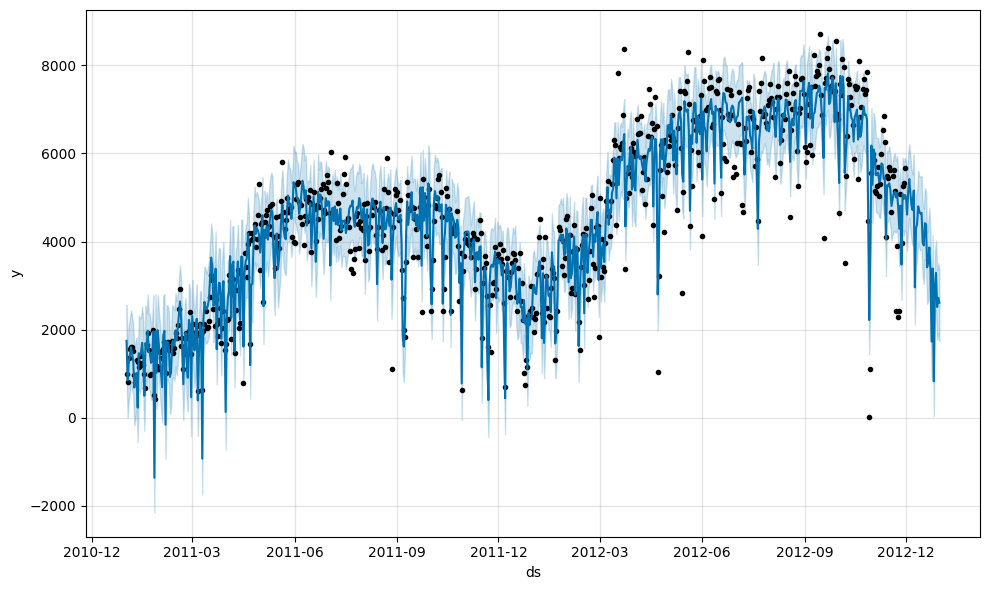

In [33]:
forecast = m2.predict(X_test)
fig = m2.plot(forecast);

/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

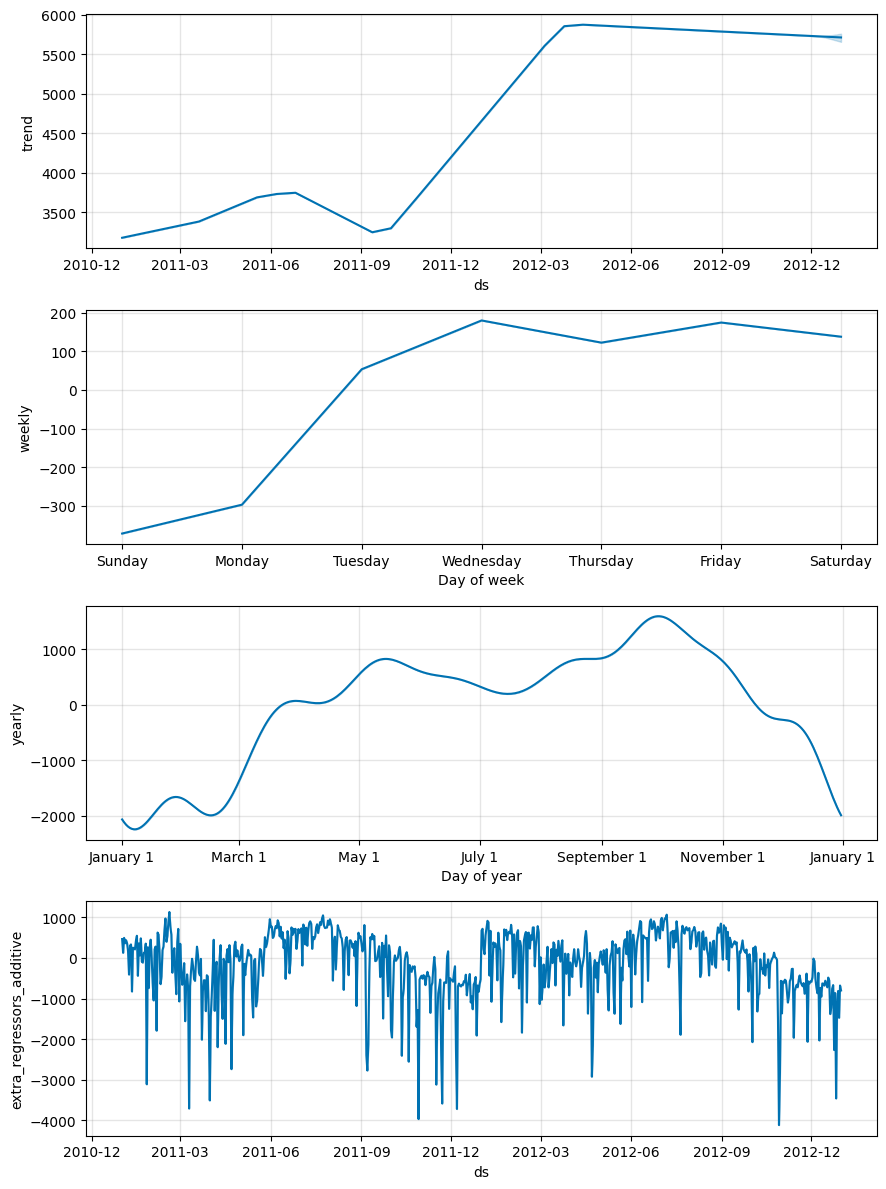

In [34]:
fig = m2.plot_components(forecast);

In [35]:
predicted = forecast[forecast.ds >= train_cut].yhat
real = y_test[-len(predicted):]

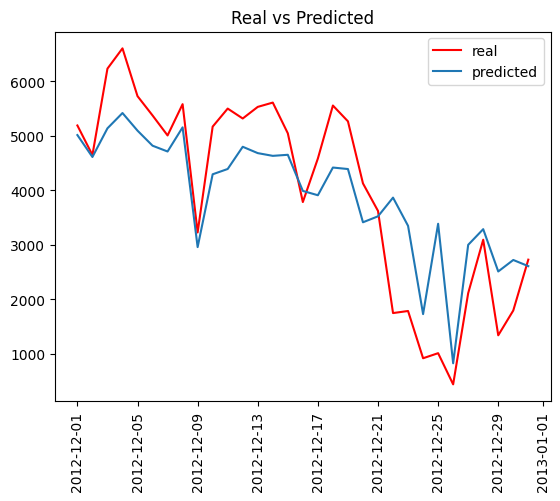

In [36]:
x = X_test.ds[-len(predicted):]
plt.plot(x, real, c='red', label='real')
plt.plot(x, predicted, label='predicted')
plt.legend()
plt.xticks(rotation='vertical')
plt.title('Real vs Predicted');

In [37]:
# imprimios evaluación
evaluate(real, predicted)

........................................................
Mean squared error: 880539.16

Coefficient of determination: 0.72

MAPE: 0.34
..........................................................


/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kdlx593/miniconda3/envs/ml_tutorials/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a

(0.0, 7.0)

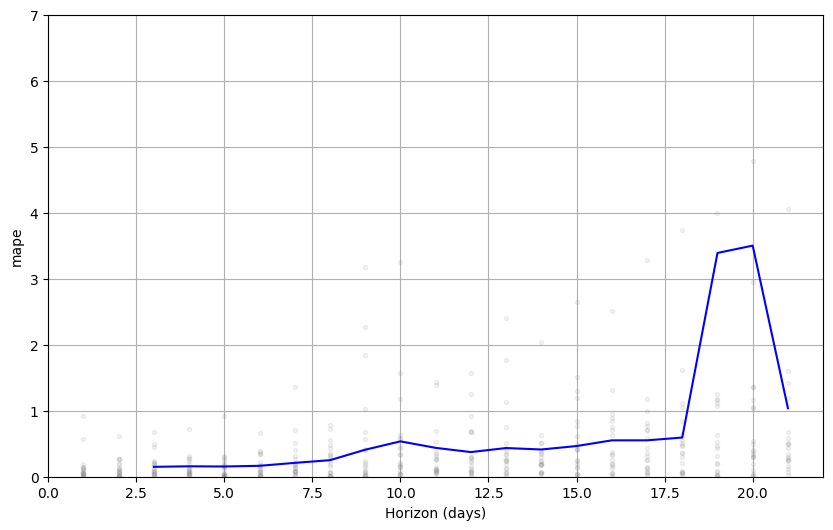

In [38]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.ylim(0,7)

# ANEXO -> Holidays de FbProphet

In [39]:
import holidays

In [40]:
for date, name in sorted(holidays.US(state='CO', years=2012).items()):
  print(date, name)

2012-01-01 New Year's Day
2012-01-02 New Year's Day (Observed)
2012-01-16 Martin Luther King Jr. Day
2012-02-20 Washington's Birthday
2012-05-28 Memorial Day
2012-07-04 Independence Day
2012-09-03 Labor Day
2012-10-08 Columbus Day
2012-11-11 Veterans Day
2012-11-12 Veterans Day (Observed)
2012-11-22 Thanksgiving
2012-12-25 Christmas Day


In [2]:
%load_ext watermark


In [46]:
%watermark -co -u -v -iv 

Last updated: 

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.17.2

conda environment: ml_tutorials

holidays  : 0.36
matplotlib: 3.6.1
sklearn   : 1.2.2
pandas    : 2.1.3
seaborn   : 0.11.1
prophet   : 1.1.5
numpy     : 1.26.2

